In [1]:
import torch
from torch.autograd import Variable
from torch.distributions import Normal
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss
import pickle
import random

In [2]:
import sys
sys.path.insert(0,'../vp_class/')

In [3]:
from class_tou_v4_updated import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

In [4]:
with open('../EX03_DW_Model', 'rb') as f:
    prior = pickle.load(f)
    likelihood = pickle.load(f)

In [5]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [6]:
true_sde_pts, true_sde_trj = prior[0], prior[1]
obs, obs_time = likelihood[0], likelihood[1]
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.1

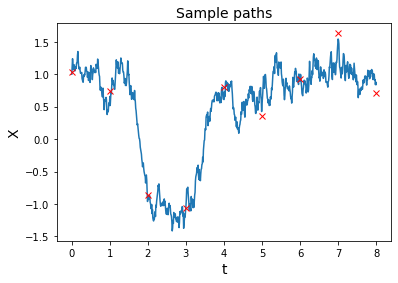

In [7]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dX_{t} = [-\frac{a}{at+b}X_{t} + (ct+d)] dt + \sigma^{2} dW_{t}$$

$$\mathbb{E}_{P^{Z}}[\log\exp{\frac{dP^{X}}{dP^{Z}}(Z)] = \frac{1}{2}\mathbb{E}_{P^{Z}}[\int_{t_{0}}}^{t_{1}}|\frac{4Z_{t}(1-Z^{2}_{t}) + \frac{a}{at+b}Z_{t} - (ct+d)}{\sigma}|^{2}dt]$$


In [8]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.r = ou.r
        
        self.sigma = ou.sigma
        

    def KL(self, prior_drift):
        """
            This function requires the function corresponding to prior drift function
        """
        # Save parameter specification from ou class
        alpha, beta, r, sigma = self.alpha, self.beta, self.r, self.sigma
        m0 = self.ou.trj[:, 0].reshape(-1, 1)
        
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)
        
        # Evaluate the drift function of the approximating processes
        g_of_x = -r * (self.ou.trj - m(t)) + m_(t)
        
        # Evaluate the drift function of the model (prior process)
        f_of_x = prior_drift(t, self.ou.trj)
        
        # Compute the term inside the KL divergence
        
        F_of_X = abs(((f_of_x - g_of_x) / sigma) ** 2)
        
        dt = t[:, -1] - t[:, 0]
        
        return 0.5 * torch.sum(F_of_X, axis=1).reshape(-1, 1) / F_of_X.shape[1] * dt.reshape(-1, 1)
            
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [9]:
import tqdm as tq

In [10]:
def score_estimate(s0, sK, current_pars, sigma, obs, obs_sigma, init_dist, M):
    """
        Returns stochastic estimates of the gradient of the ELBO with respect to parameters including
            alpha, r, beta
        
        M: # of Monte Carlo samples
        
    """
    assert obs.shape[0] == 1, "observation must be 1-d torch.array"
    
    # Number of time points drawn between s0 and sK
    K = 200
    
    # Reshape every parameter into (M,1) torch.array
    SIGMA = sigma.repeat(M, 1)
    OBS = obs.repeat(M, 1)
    # Simulate sample path
    # Note that z0 = m0
    
    pars = {key:val.repeat(M, 1) for key,val in current_pars.items()}
    
    vi = tOU(t0=s0, t1=sK, parameters = pars, sde_sigma=SIGMA, init_dist = init_dist, timegrid = 'False', dN=K)

    # Compute the ELBO 
    elbo = ELBO(vi)
    score_func = tou_gradient(vi.pts, vi.trj, pars, SIGMA, init_dist)
    f_of_x = -elbo.log_prob(OBS, obs_sigma) + elbo.KL(prior_drift)
    
    # Variational objective
    vi_obj = {'NELBO': torch.nanmean(f_of_x).item(), 'KL': torch.nanmean(elbo.KL(prior_drift)).item(), 'NLL': -1 * torch.nanmean(elbo.log_prob(OBS, obs_sigma)).item() }
    
    return {key: torch.nanmean(f_of_x * score_func[key]) for key in pars.keys()}, vi_obj

Sanity check

Examine the distribution of score function estimates of the gradient of each parameter.

In [ ]:
dist = Normal(loc=0, scale=1.)
t0 = torch.tensor(1.)
t1 = torch.tensor(2.)
sigma = torch.tensor([1.]).reshape(-1, 1)

In [ ]:
parameters = {'alpha': torch.tensor([0.15]).reshape(-1, 1), \
             'beta': torch.tensor([0.8]).reshape(-1, 1), \
             'r': torch.tensor([3.05]).reshape(-1, 1)}

In [ ]:
init_pts = torch.tensor([1.0]).reshape(-1, 1)

In [ ]:
tou = tOU(t0, t1, parameters, sigma, init_dist=init_pts)

In [ ]:
estimates = {key:[] for key in parameters.keys()}

for i in range(500):
    grads, elbo_estimate = score_estimate(t0, t1, parameters, sigma, obs[0], obs_sigma, init_pts, 2000)
    for key in grads.keys():
        estimates[key].append(grads[key].item())

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
par_names = list(estimates.keys())

for j, ax in enumerate(axs.ravel()):
    if j < 3:
        ax.hist(estimates[par_names[j]], bins=30)
        ax.axvline(np.mean(estimates[par_names[j]]), linestyle='dashed', color='black')
        ax.set_title(par_names[j])
        ax.set_xlabel("Gradient estimate")
        ax.set_ylabel("Frequency")

In [11]:
def AdamStep(g_t, m_t, v_t, beta_1, beta_2, t):
    """
        compute bias corrected moments
    """
#     print(g_t, m_t, v_t, beta_1, beta_2, t)
    m_t_next = beta_1 * m_t + (1 - beta_1) * g_t
    v_t_next = beta_2 * v_t + (1 - beta_2) * g_t ** 2
    
    m_t_corrected = m_t_next / (1 - (beta_1 ** t))
    v_t_corrected = v_t_next / (1 - (beta_2 ** t))
    
#     print(m_t_corrected, v_t_corrected)
    return m_t_corrected, v_t_corrected

def AdamGrad(current_pars, current_grad, prev_moments,  beta_1, beta_2, learning_rate = 0.01, smooth_term = 1e-8):
    assert type(current_pars) == type(current_grad) == type(prev_moments) == dict, "Current_grad must be a dict"
    """
        Perform one-step Adam gradient descent
    """
    new_pars = {}
    for key in current_pars.keys():
        if key == 'r':
            m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
            value = new_pars[key]
            while value <= 0:
                value = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
                learning_rate *= 0.5
            new_pars[key] = value
            
        else:
            m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
        
        # Save moments for next iteration    
        prev_moments[key][0] = m_t
        prev_moments[key][1] = v_t
    
    prev_moments['t'] += 1
    
    return new_pars
    
    
    

In [12]:
def E_of_X ( init_pts, pts, parameters ):
    """
        Return mean of the process (which has analytical expression)
    """

    alpha = parameters['alpha']
    beta = parameters['beta']
    r = parameters['r']
    
    return alpha * ((pts + 1) ** beta - 1) + init_pts
    

In [13]:
def V_of_X (pts, parameters, prev_parameters, sde_sigma):
    """
        Return standard deviation of the process (from its analytical expression)
    """
    r = parameters['r']
    
    if prev_parameters == False:
        # for the first time step, we compute the variance given the initial point is fixed
        return torch.sqrt(0.5 * sde_sigma * sde_sigma / r * (1 - torch.exp(-2 * r * pts)))
    
    else:
        # for subsequent time steps, we compute the variance given the initial state is a random variable from approximate posterior
        prev_r = prev_parameters['r']

        v_0 = 0.5 * sde_sigma * sde_sigma / prev_r

        return torch.sqrt(0.5 * sde_sigma * sde_sigma / r * (1 - torch.exp(-2 * r * pts) * (2*r/(sde_sigma * sde_sigma) * v_0 - 1 )))


In [14]:
def get_PostMoment(t0, tT, parameters, prev_parameters, sde_sigma, init_pts, vN):
    """
        Returns approximate posterior's mean and standard deviation
    """
    # Get time-grid between s0 and sK
    
    t = torch.linspace(0, (tT-t0).item(), vN+2)[1:].reshape(-1, 1)
    mean = E_of_X(init_pts, t, parameters)
    std = V_of_X(t, parameters, prev_parameters, sde_sigma)

    return t.flatten(), mean.flatten(), std.flatten()

**To be added: 1. parameter update history, 2. elbo, KL, and loglikelihood estimate, 3. randomizing initial state**

In [15]:
def Optimize(sde_sigma, obs, obs_time, obs_sigma, M, IT, vN, learning_rate,  init_state = "Random", Optimizer="Adam", beta_1 = 0.9, beta_2 = 0.999, smooth_term = 1e-8, FIX_PAR=False):
    """
        vN: # of time points between in each obs interval on which mean of the approximate posterior process will be evaluated
    """
    assert type(sde_sigma) == torch.Tensor, "SDE sigma must be a torch.Tensor"
    assert type(obs) == torch.Tensor, "obs must be a torch.Tensor"

    N_of_Pars = 3
    
    T = obs.shape[0]
    
    v_N = T * (vN+1) - vN
    
    VP_PTS = np.zeros(v_N)
    VP_MEAN = np.zeros(v_N)
    VP_STD = np.zeros(v_N)
    
    # Intialize the state at the first observation
    init_mean = obs[0]
    VP_MEAN[0] = init_mean
    
    past_grad = {'alpha':np.zeros((T-1, IT)), 'beta':np.zeros((T-1, IT)), 'r':np.zeros((T-1, IT))}
    past_pars = {'alpha':np.zeros((T-1, IT)), 'beta':np.zeros((T-1, IT)), 'r': np.zeros((T-1, IT))}
    past_vi = {'NELBO':np.zeros((T-1, IT)), 'KL':np.zeros((T-1, IT)), 'NLL':np.zeros((T-1, IT))}
    
    for t in tq.tqdm(range(1, T)):
        s0 = obs_time[t-1]
        sK = obs_time[t]
        
        if init_state == 'Random':
            if t == 1:
                init_dist = init_mean
            else:
                init_dist = Normal(loc=init_mean, scale= init_std)
        else:
            init_dist = init_mean
            
        # Initialize a set of parameters
        current_pars = {key:torch.randn(1) for key in past_grad.keys() if key != 'r'}
        current_pars['r'] = torch.tensor(5.)

        if Optimizer == "Adam":
            prev_moments = {key:[0, 0] for key in current_pars.keys()}
            prev_moments['t'] = 1
            
#    past_grad = {key:torch.tensor([0.01]) for key in current_pars.keys()}
    
        for i in range(IT):
            if (i % (IT/2) == 0):
                for key in current_pars.keys():
                    print(str(i) +"/ " + key + ": "+ str(current_pars[key].item()) )
                    
            # Take gradient descent algorithm based on AdaGrad
            
            # Obtain stochastic estimate of the gradients based on score function estimator
            current_grad, vi_objective = score_estimate(s0, sK, current_pars, sde_sigma, obs[t], obs_sigma, init_dist, M)
            
            for key in vi_objective.keys():
                past_vi[key][t-1, i] = vi_objective[key]
            
            print(str(i) +"/ " + "Negative ELBO: "+ str(vi_objective['NELBO']))
            
#             if vi_objective['ELBO'] < 20:
#                 break
            # Take one gradient step based on the AdaGrad
            if Optimizer == "Adam":
                current_pars = AdamGrad(current_pars, current_grad, prev_moments, beta_1, beta_2, learning_rate, smooth_term)
                
            else:
                current_pars = Grad_Descent(current_pars, current_grad, learning_rate)
            
            if FIX_PAR != False:
                for key in FIX_PAR.keys():
                    current_pars[key] = FIX_PAR[key]
            
            for key in current_grad.keys():
                past_grad[key][t-1, i] = current_grad[key].item()
                past_pars[key][t-1, i] = current_pars[key].item()
            
        if t == 1:
            prev_pars = False
            
        # Obtain moments of approximating processes (note that their forms are tractable)
        vp_pts, vp_mean, vp_std = get_PostMoment(s0, sK, current_pars, prev_pars, sde_sigma, init_mean, vN)
        VP_PTS[(vN+1)*(t-1)+1:(vN+1)*t+1] = obs_time[t-1] + vp_pts
        VP_MEAN[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_mean
        VP_STD[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_std
        
        init_mean = vp_mean[-1]
        init_std = vp_std[-1]
        
        if t > 1:
            prev_pars = current_pars
        
        print("observation: " + str(obs[t].item()) + " variational mean: " + str(init_mean.item()))
    return VP_PTS, VP_MEAN, VP_STD, past_pars, past_grad, past_vi

Examine the convergence of parameters / model fit across different initializations/number_of_iterations

In [16]:
# FIX_PAR = {'a':torch.tensor([1.])}

In [39]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
#                                                       FIX_PAR = FIX_PAR,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.07, \
                                                      Optimizer="Adam", beta_1 = 0.35, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

0/ alpha: 0.12225491553544998
0/ beta: 0.3796265423297882
0/ r: 5.0
0/ Negative ELBO: 10.335305193982117
1/ Negative ELBO: 8.884121331670373
2/ Negative ELBO: 8.339886298134857
3/ Negative ELBO: 7.2311337618607325
4/ Negative ELBO: 7.122439583589489
5/ Negative ELBO: 5.556738581669299
6/ Negative ELBO: 4.446398688080862
7/ Negative ELBO: 3.3730001455457312
8/ Negative ELBO: 2.6100602005703877
9/ Negative ELBO: 2.4680401760902777
10/ Negative ELBO: 3.187256953864937
11/ Negative ELBO: 2.674085991096062
12/ Negative ELBO: 2.262197077055327
13/ Negative ELBO: 1.8732353681728848
14/ Negative ELBO: 2.2785048618044974
15/ Negative ELBO: 2.183715830522759
16/ Negative ELBO: 2.0914412645626936
17/ Negative ELBO: 2.1509590278170925
18/ Negative ELBO: 1.9581974872732275
19/ Negative ELBO: 2.241484853373121
20/ Negative ELBO: 2.0108943566768347
21/ Negative ELBO: 2.160416475508674
22/ Negative ELBO: 1.8245394519273226
23/ Negative ELBO: 2.101690891264717
24/ Negative ELBO: 1.7826274112696083
25/ 


 12%|███████████████████████████████▍                                                                                                                                                                                                                           | 1/8 [00:04<00:29,  4.19s/it]

47/ Negative ELBO: 1.3564949097254706
48/ Negative ELBO: 1.7542828130242936
49/ Negative ELBO: 1.583854902023227
observation: 0.7418740051633642 variational mean: 0.8219731588585131
0/ alpha: -0.23961511254310608
0/ beta: -0.6989611387252808
0/ r: 5.0
0/ Negative ELBO: 164.8776566867014
1/ Negative ELBO: 158.36507328704937
2/ Negative ELBO: 152.32957562880358
3/ Negative ELBO: 147.79746868221835
4/ Negative ELBO: 146.94346866567315
5/ Negative ELBO: 145.03491949611148
6/ Negative ELBO: 140.7383973800975
7/ Negative ELBO: 136.76114698119446
8/ Negative ELBO: 135.45821996336895
9/ Negative ELBO: 127.92258576870633
10/ Negative ELBO: 120.28905964678506
11/ Negative ELBO: 115.60213550038331
12/ Negative ELBO: 110.13900911608407
13/ Negative ELBO: 102.77901636278551
14/ Negative ELBO: 96.50919948090159
15/ Negative ELBO: 87.65004075297665
16/ Negative ELBO: 81.04018848752159
17/ Negative ELBO: 74.03829367692076
18/ Negative ELBO: 67.564842474813
19/ Negative ELBO: 61.61808433806017
20/ Nega


 25%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 2/8 [00:08<00:25,  4.24s/it]

48/ Negative ELBO: 8.8915755758659
49/ Negative ELBO: 8.721449837589846
observation: -0.8564873337841266 variational mean: -0.9534849524497986
0/ alpha: -0.4935905933380127
0/ beta: -0.4717342257499695
0/ r: 5.0
0/ Negative ELBO: 9.473061722455748
1/ Negative ELBO: 9.30254920675783
2/ Negative ELBO: 8.994394620375916
3/ Negative ELBO: 8.620976796556794
4/ Negative ELBO: 87.7798639005546
5/ Negative ELBO: 72.69549041191841
6/ Negative ELBO: 55.59745785511064
7/ Negative ELBO: 41.89145431963409
8/ Negative ELBO: 29.701499206976187
9/ Negative ELBO: 19.93437868030996
10/ Negative ELBO: 14.192203079763523
11/ Negative ELBO: 10.098415831368506
12/ Negative ELBO: 8.275163978361727
13/ Negative ELBO: 8.340067249363232
14/ Negative ELBO: 7.514046817689432
15/ Negative ELBO: 7.65146554476769
16/ Negative ELBO: 7.803702246236515
17/ Negative ELBO: 7.414241197900106
18/ Negative ELBO: 7.295491333749244
19/ Negative ELBO: 7.730001045175029
20/ Negative ELBO: 6.869638750624128
21/ Negative ELBO: 7.


 38%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3/8 [00:12<00:21,  4.28s/it]

48/ Negative ELBO: 5.92122651118753
49/ Negative ELBO: 6.214996312890624
observation: -1.0673319792395932 variational mean: -1.0188186168670654
0/ alpha: -0.0519452802836895
0/ beta: 1.3180761337280273
0/ r: 5.0
0/ Negative ELBO: 197.4615225568553
1/ Negative ELBO: 170.65858744732492
2/ Negative ELBO: 148.35763285898824
3/ Negative ELBO: 127.75357482385614
4/ Negative ELBO: 105.19093519914543
5/ Negative ELBO: 86.13034885471063
6/ Negative ELBO: 67.8450311384014
7/ Negative ELBO: 48.543043071333166
8/ Negative ELBO: 34.205253867749946
9/ Negative ELBO: 19.589900371065333
10/ Negative ELBO: 10.420420324423551
11/ Negative ELBO: 10.411717477621357
12/ Negative ELBO: 18.49875387708855
13/ Negative ELBO: 10.688782962745856
14/ Negative ELBO: 9.679220800554033
15/ Negative ELBO: 8.590363728538705
16/ Negative ELBO: 11.244381770153993
17/ Negative ELBO: 9.677203081600933
18/ Negative ELBO: 8.856867914842569
19/ Negative ELBO: 8.80664529748899
20/ Negative ELBO: 32.946147794226825
21/ Negativ


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/8 [00:17<00:17,  4.28s/it]

49/ Negative ELBO: 10.735552795390257
observation: 0.7995340035602375 variational mean: 0.5948169231414795
0/ alpha: 0.4067177474498749
0/ beta: -0.5316781401634216
0/ r: 5.0
0/ Negative ELBO: 6.967374102920016
1/ Negative ELBO: 6.1876657836776525
2/ Negative ELBO: 6.510024551304538
3/ Negative ELBO: 6.27268957081684
4/ Negative ELBO: 7.469200845855446
5/ Negative ELBO: 7.275994108659043
6/ Negative ELBO: 6.8605219930424575
7/ Negative ELBO: 6.233087460437254
8/ Negative ELBO: 6.5187171983857795
9/ Negative ELBO: 6.654212872394969
10/ Negative ELBO: 7.616463061294778
11/ Negative ELBO: 6.9237868239181735
12/ Negative ELBO: 6.430942043875888
13/ Negative ELBO: 6.567368003079368
14/ Negative ELBO: 7.554472200842086
15/ Negative ELBO: 7.013281838150833
16/ Negative ELBO: 6.9946087207517875
17/ Negative ELBO: 6.017724639788053
18/ Negative ELBO: 6.0414076229849805
19/ Negative ELBO: 6.408823262519836
20/ Negative ELBO: 6.225042460328168
21/ Negative ELBO: 6.33143052637591
22/ Negative ELBO


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 5/8 [00:21<00:12,  4.27s/it]

47/ Negative ELBO: 6.978652805525689
48/ Negative ELBO: 6.687863027480583
49/ Negative ELBO: 6.499691373563863
observation: 0.3540452486520327 variational mean: 0.27745166420936584
0/ alpha: 0.6553968787193298
0/ beta: 2.614363431930542
0/ r: 5.0
0/ Negative ELBO: 3640.032345973666
1/ Negative ELBO: 1606.382622401238
2/ Negative ELBO: 457.6566319109753
3/ Negative ELBO: 40.30760274413191
4/ Negative ELBO: 43.06228277497328
5/ Negative ELBO: 31.06508011464578
6/ Negative ELBO: 5.14480767466502
7/ Negative ELBO: 61764.772492724485
8/ Negative ELBO: 54471.02109589419
9/ Negative ELBO: 44724.8288123148
10/ Negative ELBO: 34303.05832850564
11/ Negative ELBO: 26808.301443473603
12/ Negative ELBO: 20795.072371076363
13/ Negative ELBO: 15612.327541570678
14/ Negative ELBO: 11174.25068222556
15/ Negative ELBO: 7715.830877431873
16/ Negative ELBO: 5051.040885088575
17/ Negative ELBO: 3393.8403720829815
18/ Negative ELBO: 2065.8694946984483
19/ Negative ELBO: 1177.6597396900675
20/ Negative ELBO:


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6/8 [00:25<00:08,  4.26s/it]

48/ Negative ELBO: 9.8033131693835
49/ Negative ELBO: 7.685586572467911
observation: 0.9328201877376548 variational mean: 0.8015780448913574
0/ alpha: 0.4565763771533966
0/ beta: 0.34178951382637024
0/ r: 5.0
0/ Negative ELBO: 30.772620308364004
1/ Negative ELBO: 27.53918908357038
2/ Negative ELBO: 24.979763216885214
3/ Negative ELBO: 22.089417417840345
4/ Negative ELBO: 21.191976686350003
5/ Negative ELBO: 38.88674914159028
6/ Negative ELBO: 29.823553243460047
7/ Negative ELBO: 22.954460002944728
8/ Negative ELBO: 20.63763767400556
9/ Negative ELBO: 20.815394243353765
10/ Negative ELBO: 20.70288462666599
11/ Negative ELBO: 23.49841959139029
12/ Negative ELBO: 21.37045844893558
13/ Negative ELBO: 19.993086516648614
14/ Negative ELBO: 20.40566509688118
15/ Negative ELBO: 21.810451323144438
16/ Negative ELBO: 20.295373076035215
17/ Negative ELBO: 20.020448539481784
18/ Negative ELBO: 20.490450708074693
19/ Negative ELBO: 21.253090002297448
20/ Negative ELBO: 20.477668882347473
21/ Negati


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7/8 [00:29<00:04,  4.25s/it]

49/ Negative ELBO: 42.70117067377227
observation: 1.6311081388826472 variational mean: 1.5262947082519531
0/ alpha: 0.32680973410606384
0/ beta: -0.3104698359966278
0/ r: 5.0
0/ Negative ELBO: 132.2506223875357
1/ Negative ELBO: 119.1645629799411
2/ Negative ELBO: 108.23464383686314
3/ Negative ELBO: 101.45805917977633
4/ Negative ELBO: 80.04521887363886
5/ Negative ELBO: 70.55231636892721
6/ Negative ELBO: 61.09461032033728
7/ Negative ELBO: 52.735985375561924
8/ Negative ELBO: 43.560766334917986
9/ Negative ELBO: 35.35893990462951
10/ Negative ELBO: 27.478073779546843
11/ Negative ELBO: 22.02041263820098
12/ Negative ELBO: 17.933143871310744
13/ Negative ELBO: 14.405231448608344
14/ Negative ELBO: 12.893603193249811
15/ Negative ELBO: 12.843803445496892
16/ Negative ELBO: 13.935295953161114
17/ Negative ELBO: 12.67173973293721
18/ Negative ELBO: 12.13920427631946
19/ Negative ELBO: 11.767307029344938
20/ Negative ELBO: 11.966049831867155
21/ Negative ELBO: 12.41627816223896
22/ Negat


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.04s/it]

47/ Negative ELBO: 8.40847365011335
48/ Negative ELBO: 7.961185060219351
49/ Negative ELBO: 8.95575725971382
observation: 0.708966867981579 variational mean: 0.45112144947052


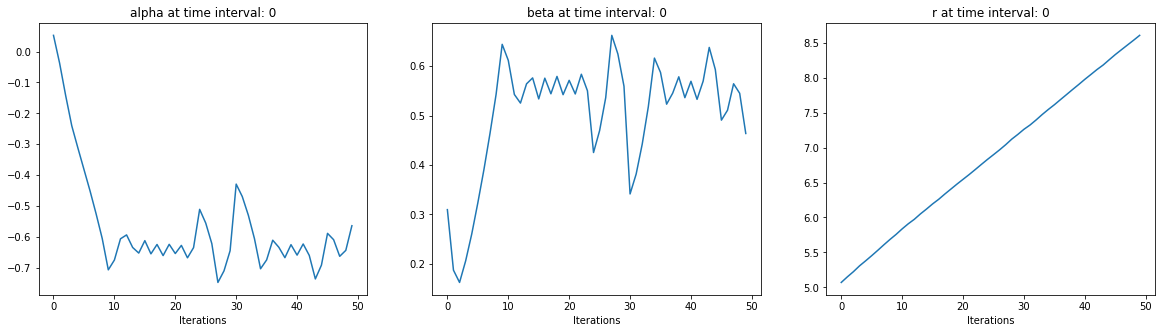

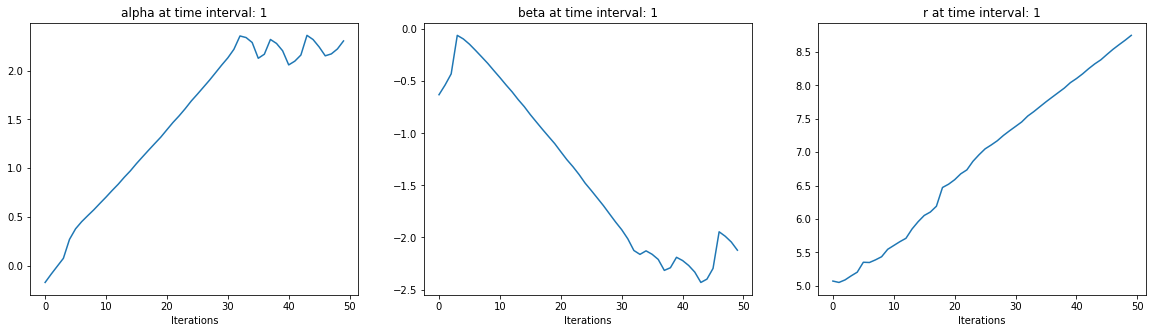

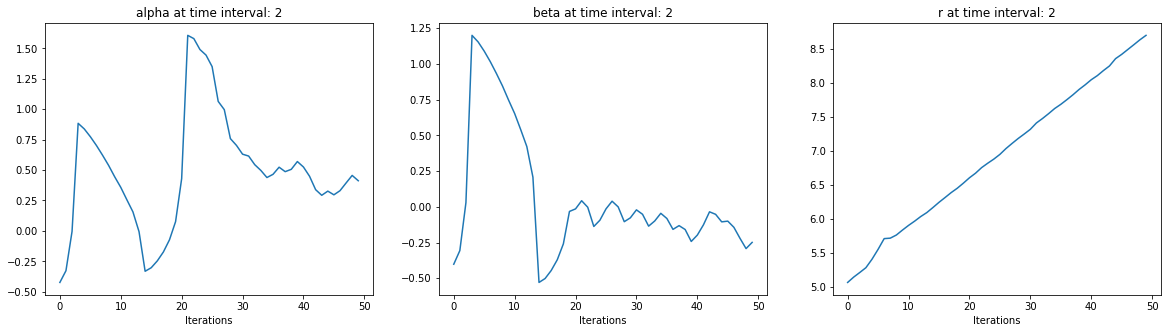

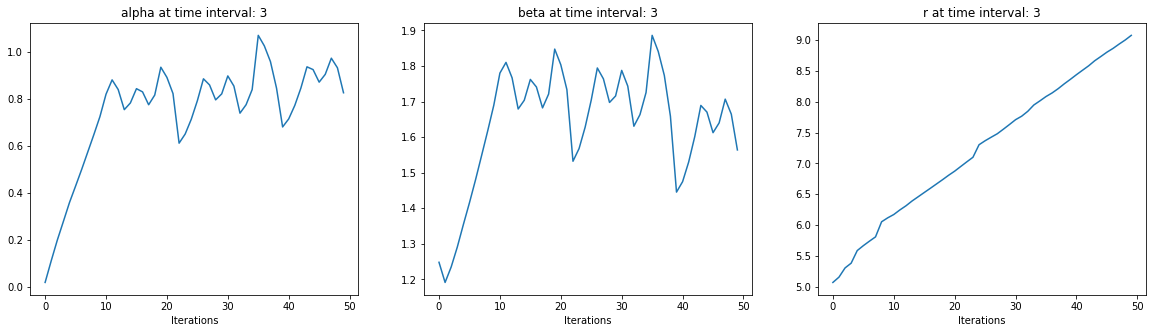

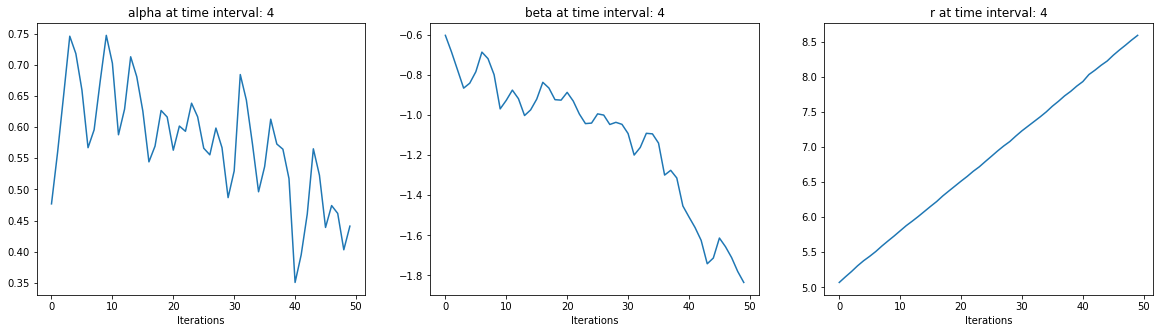

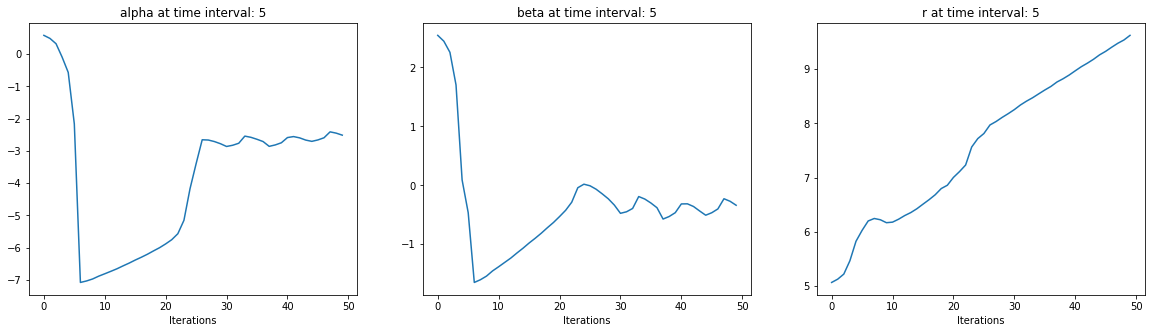

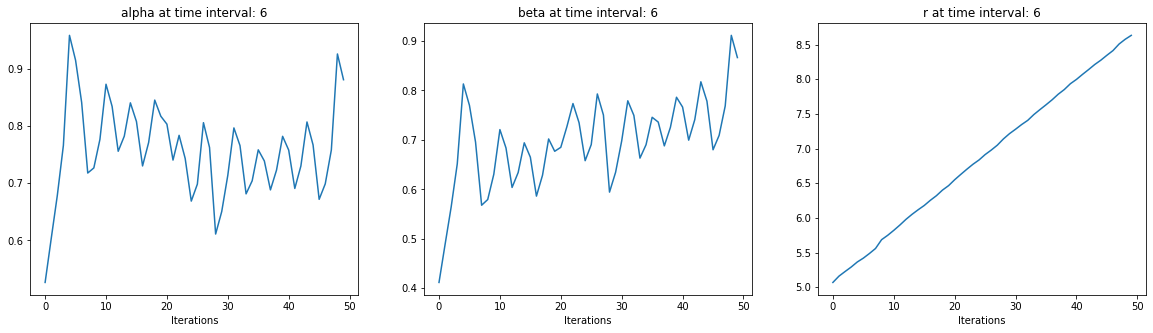

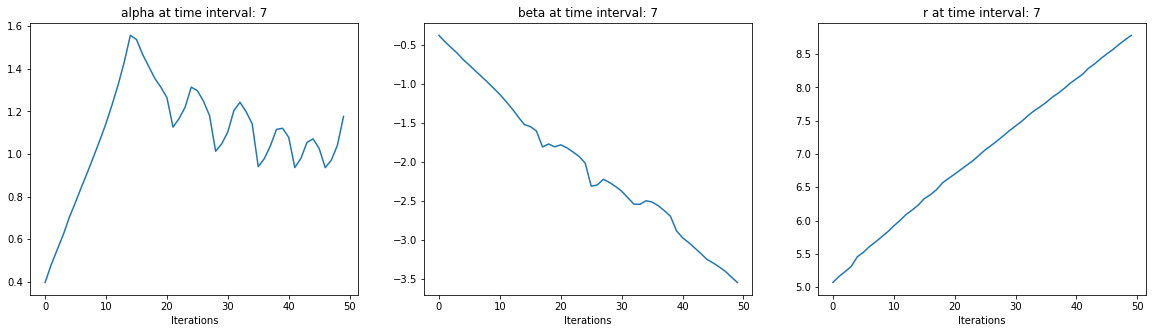

In [40]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax = plt.subplots(nrows=1, ncols=P, figsize=(20, 5))
        for j, ax in enumerate(ax.ravel()):
            ax.plot(vp__pars[par_names[j]][t, :])
            ax.set_title(par_names[j] + " at time interval: %d" % t)
            ax.set_xlabel("Iterations")
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

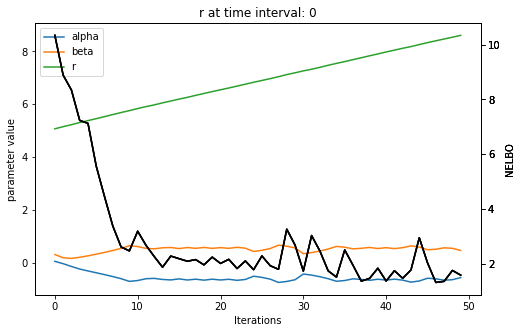

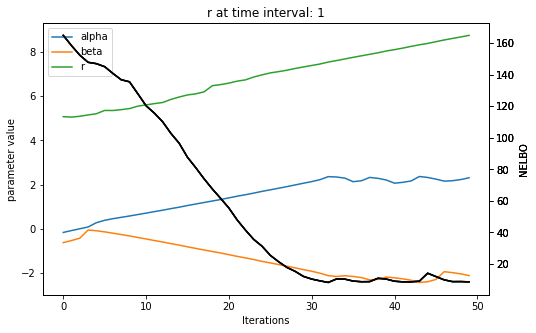

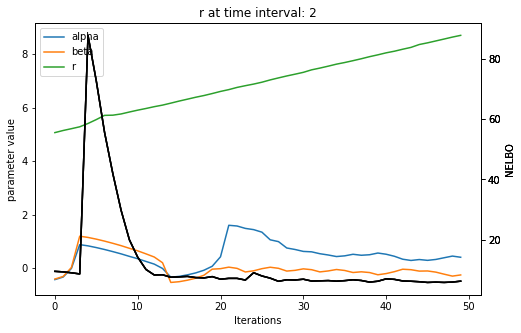

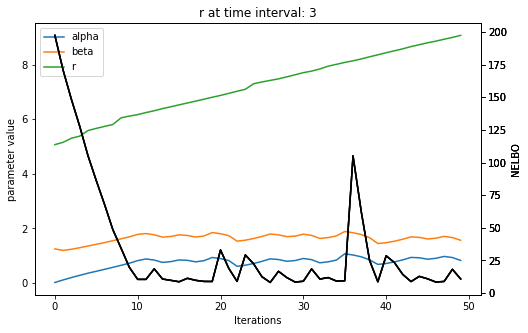

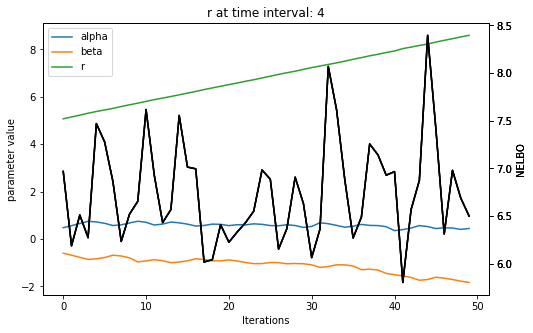

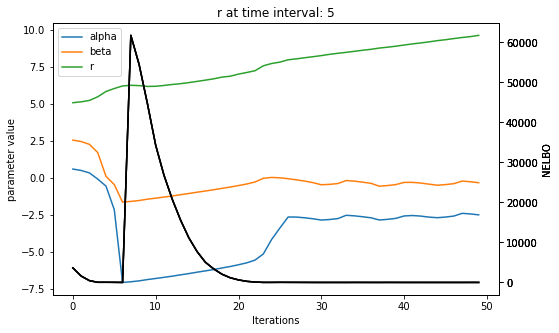

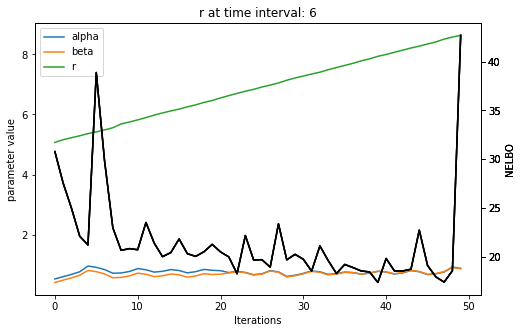

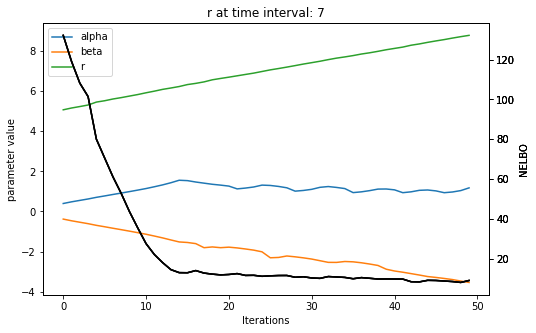

In [41]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

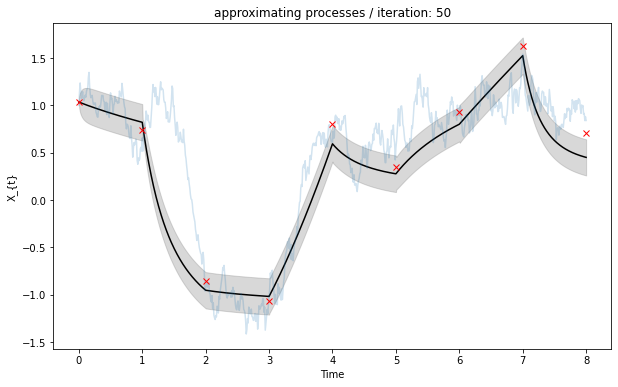

In [42]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

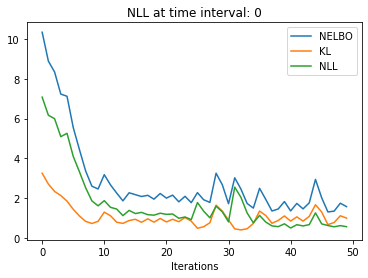

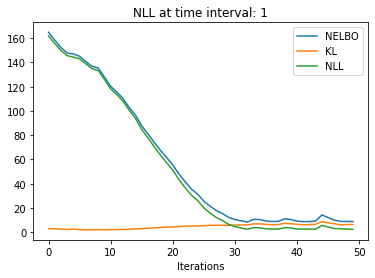

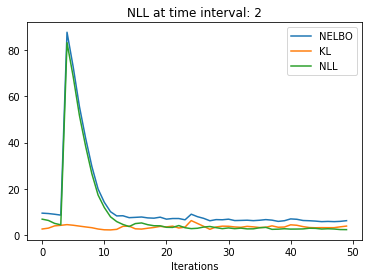

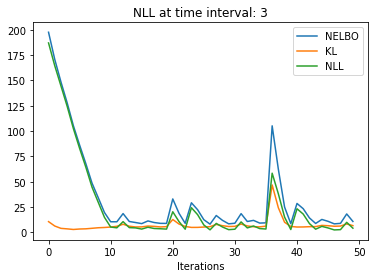

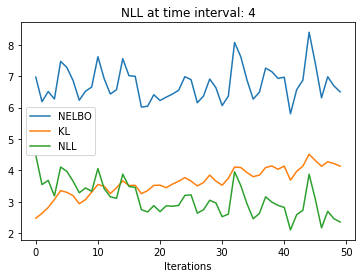

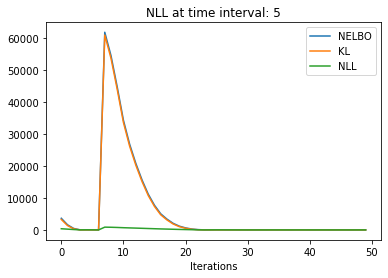

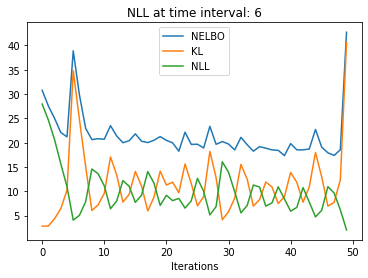

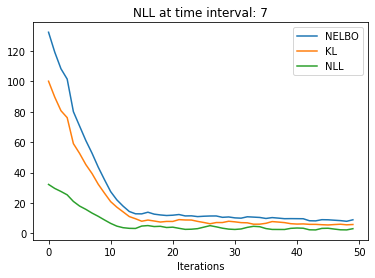

In [43]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

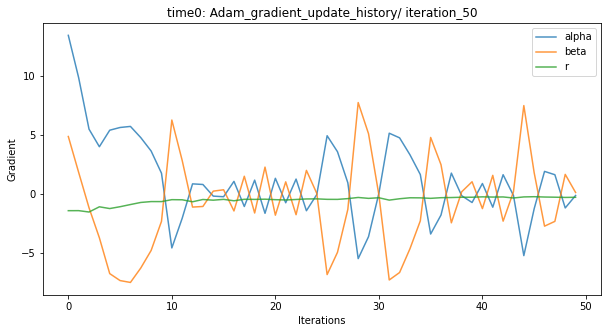

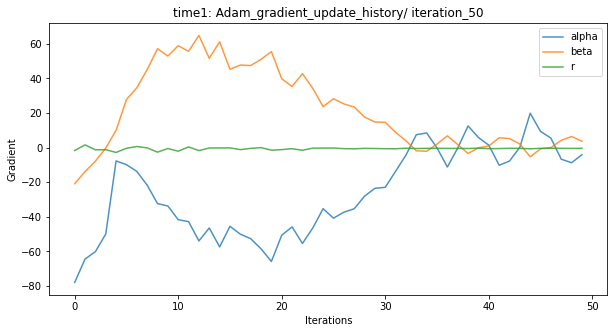

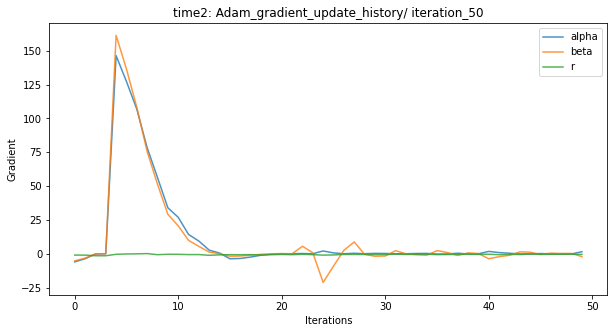

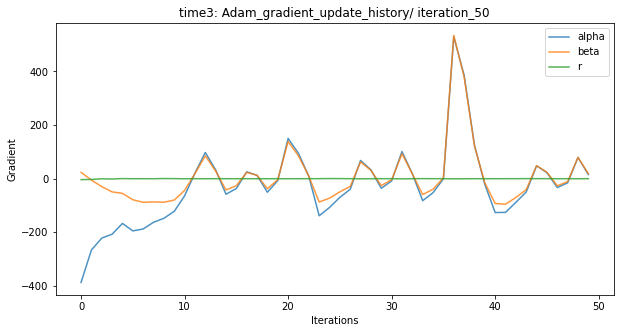

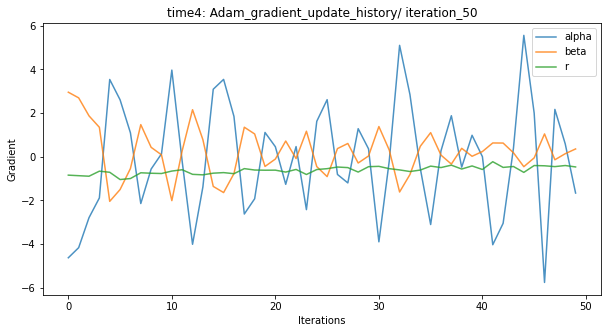

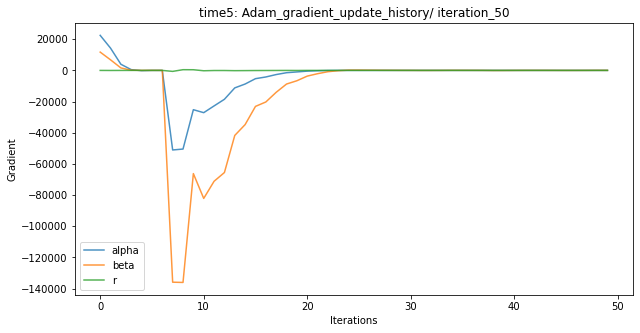

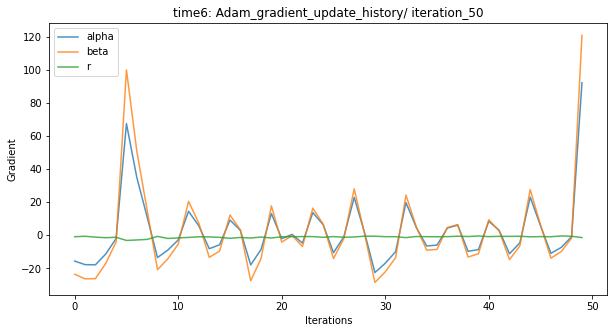

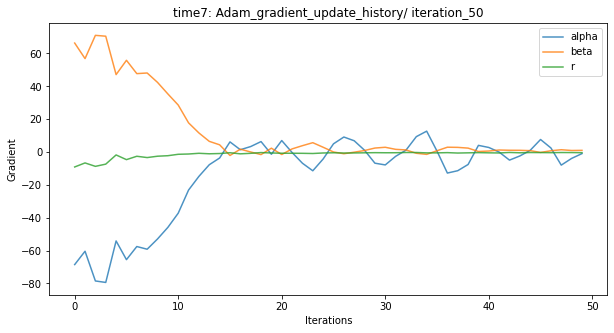

In [44]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp_grads = item[4]
    for t in range(T-1):
        plt.figure(figsize=(10,5))

        for key in vp_grads.keys():
            plt.plot(vp_grads[key][t], label=key, alpha=0.8)
            plt.ylabel("Gradient")
            plt.xlabel("Iterations")
#             plt.axhline(np.mean(vp_grads[key][t]), linestyle='dashed', label=str(np.mean(vp_grads[key]).round(2)))
            plt.legend()

        file_name = "time" + str(t) + ": Adam_" + "gradient_update_history/ " + "iteration_" + name
        plt.title(file_name)
#     plt.savefig("figures/" + file_name)
    plt.show()

Fix $\alpha$ and optimize the other paramters, $\beta, r$

In [23]:
fix_pars = {'alpha': torch.tensor(1.)}

In [24]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

0/ alpha: 0.19521205127239227
0/ beta: 0.556776225566864
0/ r: 5.0
0/ Negative ELBO: 13.935575224366534
1/ Negative ELBO: 53.19432567522339
2/ Negative ELBO: 45.98167962881906
3/ Negative ELBO: 38.88051819711099
4/ Negative ELBO: 32.43595080927742
5/ Negative ELBO: 26.33598549319306
6/ Negative ELBO: 21.85588802154238
7/ Negative ELBO: 18.004876615872394
8/ Negative ELBO: 14.223945426283384
9/ Negative ELBO: 11.633441796039808
10/ Negative ELBO: 8.878153985167028
11/ Negative ELBO: 7.377285847452282
12/ Negative ELBO: 5.345666118932554
13/ Negative ELBO: 4.513030322091606
14/ Negative ELBO: 3.6848945609380626
15/ Negative ELBO: 2.954309588145876
16/ Negative ELBO: 2.545182858215764
17/ Negative ELBO: 2.216643057265052
18/ Negative ELBO: 2.0510280895147166
19/ Negative ELBO: 2.097871082649878
20/ Negative ELBO: 2.209762339743993
21/ Negative ELBO: 2.631939602238209
22/ Negative ELBO: 2.536101556366786
23/ Negative ELBO: 2.2948480729635077
24/ Negative ELBO: 2.1405966608515863
25/ alpha:


 12%|███████████████████████████████▍                                                                                                                                                                                                                           | 1/8 [00:04<00:29,  4.23s/it]

49/ Negative ELBO: 1.9230448681905203
observation: 0.7418740051633642 variational mean: 0.7814170707685701
0/ alpha: -1.4602978229522705
0/ beta: 1.3015835285186768
0/ r: 5.0
0/ Negative ELBO: 28.215049071075352
1/ Negative ELBO: 721.0725476873059
2/ Negative ELBO: 660.6928131591326
3/ Negative ELBO: 586.2907925686605
4/ Negative ELBO: 537.7687767477437
5/ Negative ELBO: 481.48425893403373
6/ Negative ELBO: 444.9852309221828
7/ Negative ELBO: 406.86972338259017
8/ Negative ELBO: 367.5399490081491
9/ Negative ELBO: 340.03084356605626
10/ Negative ELBO: 312.7821195894556
11/ Negative ELBO: 298.27094110113023
12/ Negative ELBO: 275.3713608274868
13/ Negative ELBO: 260.0736702959581
14/ Negative ELBO: 242.71289211067597
15/ Negative ELBO: 231.24475380656727
16/ Negative ELBO: 217.2133789135969
17/ Negative ELBO: 202.00849117397695
18/ Negative ELBO: 194.0197766422724
19/ Negative ELBO: 185.09193712714819
20/ Negative ELBO: 174.03100311008984
21/ Negative ELBO: 164.35667046089384
22/ Negati


 25%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 2/8 [00:08<00:25,  4.24s/it]

47/ Negative ELBO: 66.14984287054061
48/ Negative ELBO: 63.84819600909456
49/ Negative ELBO: 64.81259846117919
observation: -0.8564873337841266 variational mean: 0.19196361303329468
0/ alpha: -0.4735960364341736
0/ beta: -0.522691011428833
0/ r: 5.0
0/ Negative ELBO: 103.7832431084606
1/ Negative ELBO: 55.79028901067254
2/ Negative ELBO: 53.55342574994951
3/ Negative ELBO: 51.62917936701951
4/ Negative ELBO: 50.142935502981075
5/ Negative ELBO: 46.41790316972293
6/ Negative ELBO: 46.333533518269
7/ Negative ELBO: 44.00870374259801
8/ Negative ELBO: 41.467157288482774
9/ Negative ELBO: 39.13617108942828
10/ Negative ELBO: 37.80395424026064
11/ Negative ELBO: 36.71535012582949
12/ Negative ELBO: 34.81821092632096
13/ Negative ELBO: 34.638032365045724
14/ Negative ELBO: 34.06999168530985
15/ Negative ELBO: 31.906657624470476
16/ Negative ELBO: 30.608137347603453
17/ Negative ELBO: 29.067970361923713
18/ Negative ELBO: 27.41749260051127
19/ Negative ELBO: 27.279873742192304
20/ Negative EL


 38%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3/8 [00:12<00:21,  4.24s/it]

48/ Negative ELBO: 13.897253391115076
49/ Negative ELBO: 14.04342227392769
observation: -1.0673319792395932 variational mean: -0.6792570948600769
0/ alpha: 0.457131952047348
0/ beta: -0.6872027516365051
0/ r: 5.0
0/ Negative ELBO: 144.12977193084217
1/ Negative ELBO: 178.2195633078451
2/ Negative ELBO: 176.40170184604918
3/ Negative ELBO: 168.9849395039951
4/ Negative ELBO: 163.6853265928839
5/ Negative ELBO: 157.32631731754142
6/ Negative ELBO: 154.64549787343455
7/ Negative ELBO: 151.25600166230325
8/ Negative ELBO: 144.78208413582752
9/ Negative ELBO: 138.190603038458
10/ Negative ELBO: 134.862041765305
11/ Negative ELBO: 126.19914696088726
12/ Negative ELBO: 122.96688456452814
13/ Negative ELBO: 118.81940566539538
14/ Negative ELBO: 114.28160457956203
15/ Negative ELBO: 109.10161657967814
16/ Negative ELBO: 104.48694209102027
17/ Negative ELBO: 98.78548188224023
18/ Negative ELBO: 94.56887012100107
19/ Negative ELBO: 90.27530521534426
20/ Negative ELBO: 83.8857770078818
21/ Negativ


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/8 [00:17<00:17,  4.26s/it]

49/ Negative ELBO: 8.121028180005704
observation: 0.7995340035602375 variational mean: 0.6612594723701477
0/ alpha: -1.0210984945297241
0/ beta: -1.1230214834213257
0/ r: 5.0
0/ Negative ELBO: 52.94654122035486
1/ Negative ELBO: 9.826465165073321
2/ Negative ELBO: 9.42629040581348
3/ Negative ELBO: 8.000538977377467
4/ Negative ELBO: 7.664305661702909
5/ Negative ELBO: 7.540688302264858
6/ Negative ELBO: 6.985599126237379
7/ Negative ELBO: 6.96825921153026
8/ Negative ELBO: 7.005025800657165
9/ Negative ELBO: 6.6409272455405635
10/ Negative ELBO: 6.919869414962708
11/ Negative ELBO: 6.721986322083051
12/ Negative ELBO: 7.375180650672509
13/ Negative ELBO: 6.861028256800785
14/ Negative ELBO: 6.908199284235239
15/ Negative ELBO: 6.998873359613829
16/ Negative ELBO: 6.658402113464283
17/ Negative ELBO: 7.056947362108185
18/ Negative ELBO: 6.730829560135791
19/ Negative ELBO: 7.005058348851225
20/ Negative ELBO: 6.8616414712629705
21/ Negative ELBO: 7.357814169354906
22/ Negative ELBO: 7.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 5/8 [00:21<00:12,  4.28s/it]

47/ Negative ELBO: 7.322261959978849
48/ Negative ELBO: 7.215318896492186
49/ Negative ELBO: 7.029595489224664
observation: 0.3540452486520327 variational mean: 0.27689647674560547
0/ alpha: 0.9510700702667236
0/ beta: -0.7603187561035156
0/ r: 5.0
0/ Negative ELBO: 63.39735580781298
1/ Negative ELBO: 60.35582478546896
2/ Negative ELBO: 59.387889594643134
3/ Negative ELBO: 57.16395259446818
4/ Negative ELBO: 54.75146515754761
5/ Negative ELBO: 52.52951633220144
6/ Negative ELBO: 49.68780089482044
7/ Negative ELBO: 48.53973459756772
8/ Negative ELBO: 44.00108076871067
9/ Negative ELBO: 43.22950860245382
10/ Negative ELBO: 40.26753257641274
11/ Negative ELBO: 37.692369270436245
12/ Negative ELBO: 34.364662582375765
13/ Negative ELBO: 32.911189425550404
14/ Negative ELBO: 31.594941502531853
15/ Negative ELBO: 29.201840850716078
16/ Negative ELBO: 25.65803593827689
17/ Negative ELBO: 22.983982915624917
18/ Negative ELBO: 20.131213210800134
19/ Negative ELBO: 18.869964633607292
20/ Negative


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6/8 [00:25<00:08,  4.28s/it]

48/ Negative ELBO: 4.91414762769204
49/ Negative ELBO: 5.057961305899163
observation: 0.9328201877376548 variational mean: 0.86399245262146
0/ alpha: 0.8668582439422607
0/ beta: -1.2174975872039795
0/ r: 5.0
0/ Negative ELBO: 87.21272199994428
1/ Negative ELBO: 96.99666306550704
2/ Negative ELBO: 95.67815918294292
3/ Negative ELBO: 90.1108894301769
4/ Negative ELBO: 89.22355473340284
5/ Negative ELBO: 84.75251131712493
6/ Negative ELBO: 83.16642338038169
7/ Negative ELBO: 80.60353639182786
8/ Negative ELBO: 80.10680615493365
9/ Negative ELBO: 73.53191531953199
10/ Negative ELBO: 72.35033859458049
11/ Negative ELBO: 70.36993951076298
12/ Negative ELBO: 67.69487523035367
13/ Negative ELBO: 65.44083346071389
14/ Negative ELBO: 62.495478215860565
15/ Negative ELBO: 61.051442201653494
16/ Negative ELBO: 55.719132981104046
17/ Negative ELBO: 56.20622304909432
18/ Negative ELBO: 52.43233522526245
19/ Negative ELBO: 48.96795485337179
20/ Negative ELBO: 46.7002905598835
21/ Negative ELBO: 43.05


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7/8 [00:29<00:04,  4.29s/it]

49/ Negative ELBO: 22.461934286181215
observation: 1.6311081388826472 variational mean: 1.2673957347869873
0/ alpha: 0.803236722946167
0/ beta: -1.8956100940704346
0/ r: 5.0
0/ Negative ELBO: 8.195235375152647
1/ Negative ELBO: 9.972421151779368
2/ Negative ELBO: 9.540960631316663
3/ Negative ELBO: 9.381766374406551
4/ Negative ELBO: 9.341128870377888
5/ Negative ELBO: 9.168553920907472
6/ Negative ELBO: 9.147612281213645
7/ Negative ELBO: 8.92952393795407
8/ Negative ELBO: 8.811703787715492
9/ Negative ELBO: 8.473107955205853
10/ Negative ELBO: 8.701976208015266
11/ Negative ELBO: 8.308622598749299
12/ Negative ELBO: 8.500813695209592
13/ Negative ELBO: 8.373969303177352
14/ Negative ELBO: 8.668193773424633
15/ Negative ELBO: 8.615404127477337
16/ Negative ELBO: 7.823376145577802
17/ Negative ELBO: 8.14699728551518
18/ Negative ELBO: 8.419140794622884
19/ Negative ELBO: 8.14365869012609
20/ Negative ELBO: 8.121188188048356
21/ Negative ELBO: 8.421581715134
22/ Negative ELBO: 7.8060260


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.24s/it]

47/ Negative ELBO: 7.71819431842569
48/ Negative ELBO: 7.550190180326538
49/ Negative ELBO: 7.529059001108777
observation: 0.708966867981579 variational mean: 0.6270672082901001


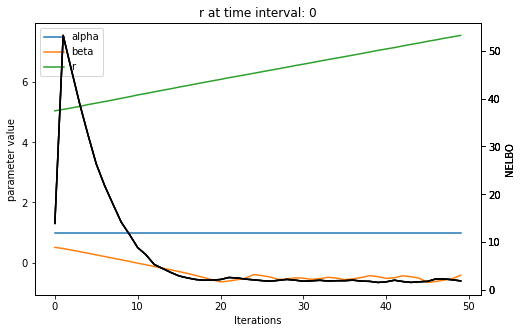

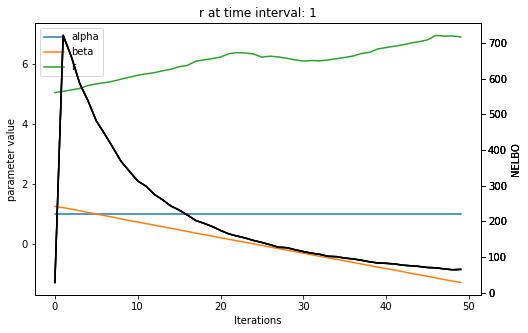

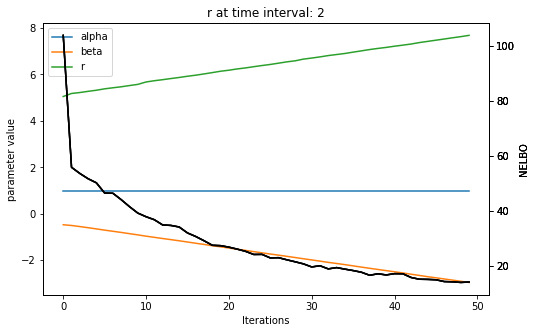

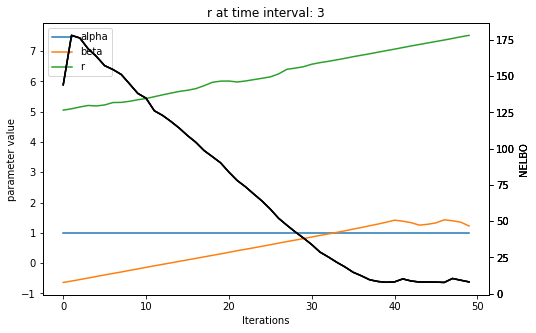

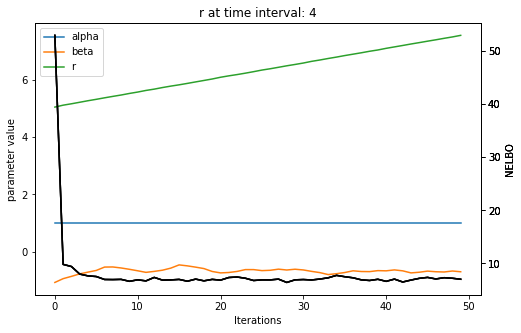

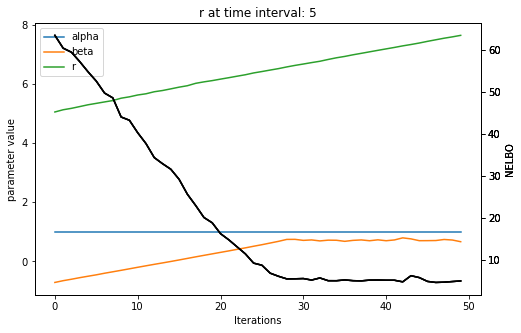

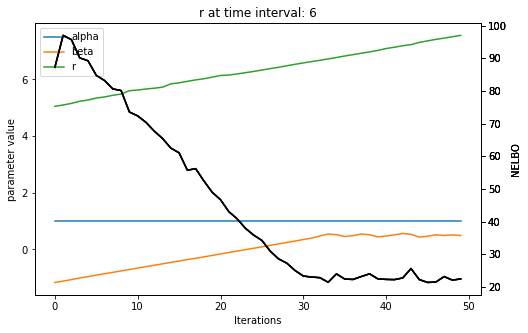

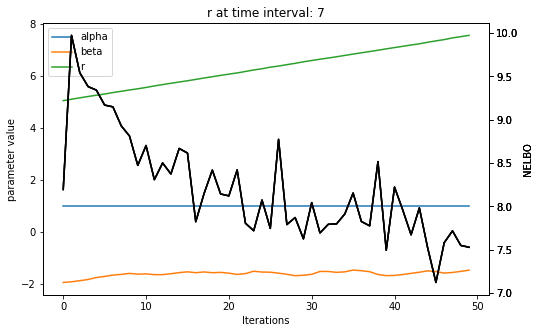

In [25]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

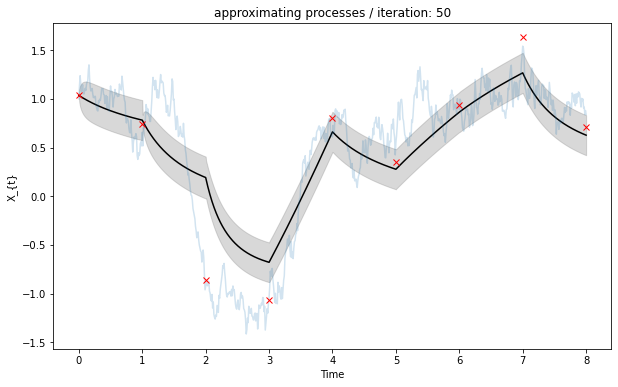

In [26]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

FIX $\beta$

In [27]:
fix_pars = {'beta': torch.tensor(1.)}

In [28]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

0/ alpha: -0.10366527736186981
0/ beta: -2.5696418285369873
0/ r: 5.0
0/ Negative ELBO: 14.170175372657301
1/ Negative ELBO: 6.9833393961736485
2/ Negative ELBO: 5.941760785100254
3/ Negative ELBO: 4.780141740957418
4/ Negative ELBO: 3.3785625721572554
5/ Negative ELBO: 2.7476276329453144
6/ Negative ELBO: 2.6439417543730377
7/ Negative ELBO: 3.011678010593983
8/ Negative ELBO: 2.945601210124426
9/ Negative ELBO: 2.5501371467054263
10/ Negative ELBO: 2.336587894670338
11/ Negative ELBO: 2.41625180659106
12/ Negative ELBO: 2.514658248190331
13/ Negative ELBO: 2.441420806472319
14/ Negative ELBO: 2.1030945635679617
15/ Negative ELBO: 2.250958659403511
16/ Negative ELBO: 2.6357879744506882
17/ Negative ELBO: 2.1427811923104763
18/ Negative ELBO: 2.037956219074084
19/ Negative ELBO: 2.088421705902826
20/ Negative ELBO: 2.5100011834894773
21/ Negative ELBO: 2.2398429956073955
22/ Negative ELBO: 1.8629525910455371
23/ Negative ELBO: 2.181431639993773
24/ Negative ELBO: 2.1663427490053255
25/


 12%|███████████████████████████████▍                                                                                                                                                                                                                           | 1/8 [00:04<00:28,  4.14s/it]

49/ Negative ELBO: 1.6194184621637506
observation: 0.7418740051633642 variational mean: 0.737074791334366
0/ alpha: -0.059248119592666626
0/ beta: 0.7031153440475464
0/ r: 5.0
0/ Negative ELBO: 125.32486918129925
1/ Negative ELBO: 115.26527004100272
2/ Negative ELBO: 109.12117996900692
3/ Negative ELBO: 102.40562599695008
4/ Negative ELBO: 95.02841009937406
5/ Negative ELBO: 88.86697451873357
6/ Negative ELBO: 81.74836363900656
7/ Negative ELBO: 76.23949645385437
8/ Negative ELBO: 69.89798097624035
9/ Negative ELBO: 66.04930841320669
10/ Negative ELBO: 61.57150409934074
11/ Negative ELBO: 55.36798899688744
12/ Negative ELBO: 50.07291671371562
13/ Negative ELBO: 45.52997030215169
14/ Negative ELBO: 41.22235644927292
15/ Negative ELBO: 37.6744337496368
16/ Negative ELBO: 33.06131865906936
17/ Negative ELBO: 29.700822380427446
18/ Negative ELBO: 25.63146405437962
19/ Negative ELBO: 24.683456156445445
20/ Negative ELBO: 21.26032789288965
21/ Negative ELBO: 18.233374016317477
22/ Negative E


 25%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 2/8 [00:08<00:24,  4.16s/it]

47/ Negative ELBO: 8.671552500265422
48/ Negative ELBO: 9.073184284265174
49/ Negative ELBO: 8.312547728620634
observation: -0.8564873337841266 variational mean: -0.9251927733421326
0/ alpha: -1.3746718168258667
0/ beta: -0.37720149755477905
0/ r: 5.0
0/ Negative ELBO: 16.811898854163033
1/ Negative ELBO: 469.04456082390357
2/ Negative ELBO: 412.02312749618153
3/ Negative ELBO: 365.06326268868884
4/ Negative ELBO: 326.87198961364294
5/ Negative ELBO: 283.57125061679267
6/ Negative ELBO: 245.39925766769804
7/ Negative ELBO: 209.68347054149285
8/ Negative ELBO: 172.18567300565286
9/ Negative ELBO: 154.93650253563175
10/ Negative ELBO: 135.4961305300688
11/ Negative ELBO: 115.03946950143114
12/ Negative ELBO: 100.65401935457102
13/ Negative ELBO: 79.00318716655184
14/ Negative ELBO: 68.53201475370797
15/ Negative ELBO: 52.20321224692109
16/ Negative ELBO: 42.12539616404989
17/ Negative ELBO: 37.08754643343371
18/ Negative ELBO: 28.32361100555999
19/ Negative ELBO: 24.000265339098334
20/ N


 38%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3/8 [00:12<00:20,  4.17s/it]

48/ Negative ELBO: 7.349758235767297
49/ Negative ELBO: 7.281240313539822
observation: -1.0673319792395932 variational mean: -0.9402433037757874
0/ alpha: 0.9497608542442322
0/ beta: -0.04580976068973541
0/ r: 5.0
0/ Negative ELBO: 165.03794483531988
1/ Negative ELBO: 41.77188763316105
2/ Negative ELBO: 39.5671879717655
3/ Negative ELBO: 36.48777353779872
4/ Negative ELBO: 33.26876436233283
5/ Negative ELBO: 29.86286461815205
6/ Negative ELBO: 26.64097620235245
7/ Negative ELBO: 22.68155948369823
8/ Negative ELBO: 20.29722198152449
9/ Negative ELBO: 18.42975839373092
10/ Negative ELBO: 16.289318792691038
11/ Negative ELBO: 13.603783179687909
12/ Negative ELBO: 12.892786774061094
13/ Negative ELBO: 11.173493757109371
14/ Negative ELBO: 9.844165591373683
15/ Negative ELBO: 9.239069647849098
16/ Negative ELBO: 8.84817398404649
17/ Negative ELBO: 8.772570878631345
18/ Negative ELBO: 8.753859860844212
19/ Negative ELBO: 9.112721445493348
20/ Negative ELBO: 9.412019802305846
21/ Negative ELB


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/8 [00:16<00:16,  4.20s/it]

49/ Negative ELBO: 8.541025741120922
observation: 0.7995340035602375 variational mean: 0.8742408156394958
0/ alpha: -1.6727992296218872
0/ beta: -0.3672604560852051
0/ r: 5.0
0/ Negative ELBO: 61.01572845543467
1/ Negative ELBO: 70.76903930063432
2/ Negative ELBO: 64.40618402048312
3/ Negative ELBO: 58.41712713390671
4/ Negative ELBO: 53.38078327055132
5/ Negative ELBO: 49.82968521852672
6/ Negative ELBO: 45.44000965831082
7/ Negative ELBO: 40.99915099428817
8/ Negative ELBO: 36.86772077543592
9/ Negative ELBO: 32.81654464088168
10/ Negative ELBO: 28.6557937859466
11/ Negative ELBO: 25.137260778791543
12/ Negative ELBO: 23.724963884557276
13/ Negative ELBO: 19.430889959212436
14/ Negative ELBO: 17.06643276935622
15/ Negative ELBO: 14.599833364563999
16/ Negative ELBO: 13.014417935151563
17/ Negative ELBO: 11.02623531626268
18/ Negative ELBO: 9.363838072161455
19/ Negative ELBO: 8.078034404542523
20/ Negative ELBO: 7.243298213092203
21/ Negative ELBO: 6.278077403327368
22/ Negative ELBO


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 5/8 [00:20<00:12,  4.21s/it]

47/ Negative ELBO: 8.19682506211632
48/ Negative ELBO: 7.810481314771981
49/ Negative ELBO: 7.202633879505957
observation: 0.3540452486520327 variational mean: 0.36425912380218506
0/ alpha: 0.5845704078674316
0/ beta: 0.5590199828147888
0/ r: 5.0
0/ Negative ELBO: 9.722075986348244
1/ Negative ELBO: 6.564778752868554
2/ Negative ELBO: 6.306828312367111
3/ Negative ELBO: 5.759006773184194
4/ Negative ELBO: 6.050601517789585
5/ Negative ELBO: 5.927986764057393
6/ Negative ELBO: 5.8961366320687
7/ Negative ELBO: 5.895509162912057
8/ Negative ELBO: 5.709624545115255
9/ Negative ELBO: 5.45879566289619
10/ Negative ELBO: 5.677090784488969
11/ Negative ELBO: 5.669958719167499
12/ Negative ELBO: 5.906751127461855
13/ Negative ELBO: 6.156267339380248
14/ Negative ELBO: 5.858645379751898
15/ Negative ELBO: 5.494609569019549
16/ Negative ELBO: 5.297910790455023
17/ Negative ELBO: 5.927011355715531
18/ Negative ELBO: 5.312048458774845
19/ Negative ELBO: 5.1705177167253105
20/ Negative ELBO: 7.4054


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6/8 [00:25<00:08,  4.22s/it]

48/ Negative ELBO: 5.169876844545094
49/ Negative ELBO: 5.090181277139536
observation: 0.9328201877376548 variational mean: 0.8662025332450867
0/ alpha: 0.30247023701667786
0/ beta: -1.3324897289276123
0/ r: 5.0
0/ Negative ELBO: 51.11031238702408
1/ Negative ELBO: 25.37063055861783
2/ Negative ELBO: 24.52095579657986
3/ Negative ELBO: 25.235652164682463
4/ Negative ELBO: 24.224315928094832
5/ Negative ELBO: 25.29654168255814
6/ Negative ELBO: 24.703464015020163
7/ Negative ELBO: 25.02552296697223
8/ Negative ELBO: 24.755492558793737
9/ Negative ELBO: 24.873840601687533
10/ Negative ELBO: 24.204504971235572
11/ Negative ELBO: 25.208356787118834
12/ Negative ELBO: 25.239668783047712
13/ Negative ELBO: 24.177988211010078
14/ Negative ELBO: 23.248129559267255
15/ Negative ELBO: 23.120159086235837
16/ Negative ELBO: 24.11857512051266
17/ Negative ELBO: 25.430319921738775
18/ Negative ELBO: 23.778669240827806
19/ Negative ELBO: 23.792611497121946
20/ Negative ELBO: 23.50433312020825
21/ Neg


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7/8 [00:29<00:04,  4.23s/it]

49/ Negative ELBO: 20.760810370731996
observation: 1.6311081388826472 variational mean: 1.3153702020645142
0/ alpha: -0.49349820613861084
0/ beta: 0.9163207411766052
0/ r: 5.0
0/ Negative ELBO: 19.10581259798793
1/ Negative ELBO: 15.559936360766976
2/ Negative ELBO: 12.739343582530724
3/ Negative ELBO: 13.409219685720867
4/ Negative ELBO: 13.044753275271676
5/ Negative ELBO: 13.515969884989614
6/ Negative ELBO: 12.45198487460835
7/ Negative ELBO: 13.11289001827343
8/ Negative ELBO: 13.168569757223144
9/ Negative ELBO: 13.693128712504944
10/ Negative ELBO: 13.755176352216672
11/ Negative ELBO: 13.080915205855032
12/ Negative ELBO: 12.734636883875865
13/ Negative ELBO: 12.293018753406264
14/ Negative ELBO: 13.402196094448213
15/ Negative ELBO: 12.268906863412306
16/ Negative ELBO: 12.28440675434375
17/ Negative ELBO: 12.43542014041331
18/ Negative ELBO: 11.951019111685394
19/ Negative ELBO: 11.841562230080546
20/ Negative ELBO: 12.415348326811213
21/ Negative ELBO: 12.354708263582744
22/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.70s/it]

47/ Negative ELBO: 11.772841457593342
48/ Negative ELBO: 11.171015292161261
49/ Negative ELBO: 11.883510414820103
observation: 0.708966867981579 variational mean: 0.6122590899467468


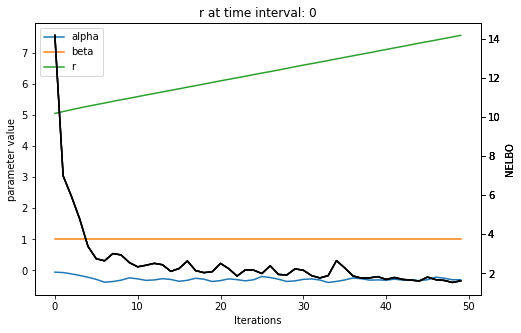

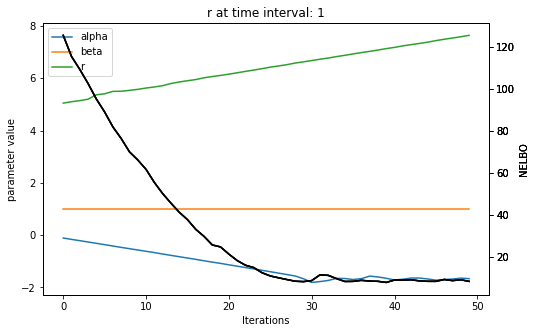

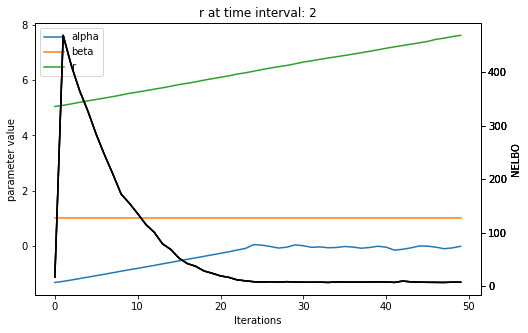

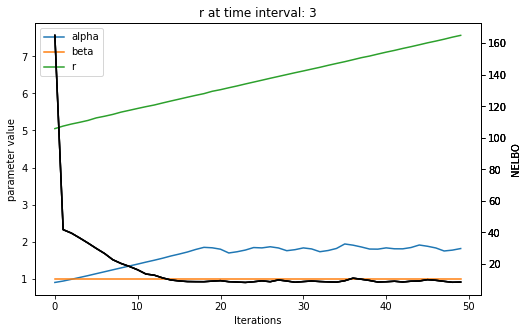

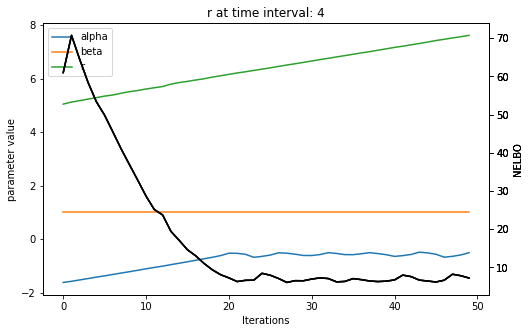

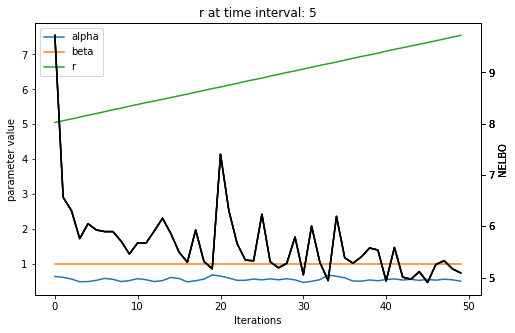

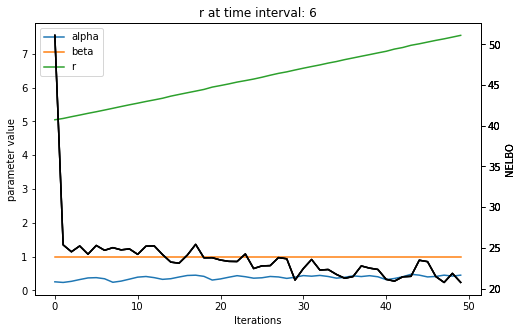

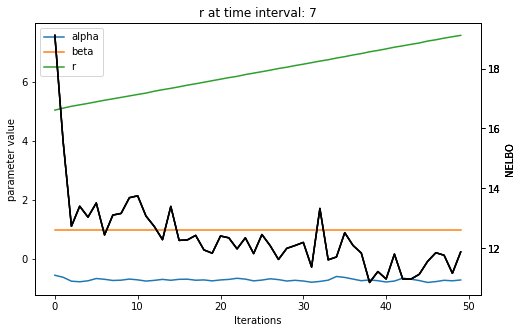

In [29]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

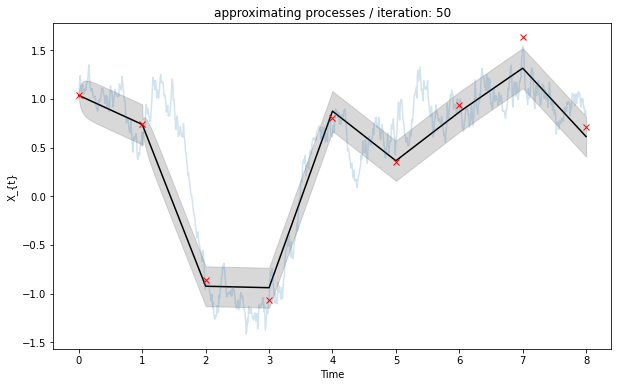

In [30]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

FIX $\alpha, \beta$

In [31]:
fix_pars = {'beta': torch.tensor(1.), 'alpha':torch.tensor(2.)}

In [32]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.1, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

0/ alpha: 1.4708523750305176
0/ beta: 1.324866533279419
0/ r: 5.0
0/ Negative ELBO: 3019.5461238451785
1/ Negative ELBO: 2195.2674541703354
2/ Negative ELBO: 2162.5808037763836
3/ Negative ELBO: 2205.575308934022
4/ Negative ELBO: 2200.8691555390956
5/ Negative ELBO: 2180.670384655333
6/ Negative ELBO: 2178.5995263922837
7/ Negative ELBO: 2156.1866434991553
8/ Negative ELBO: 2174.6351335921904
9/ Negative ELBO: 2164.5688881197393
10/ Negative ELBO: 2165.5069138928907
11/ Negative ELBO: 2148.6686990032736
12/ Negative ELBO: 2156.282276132338
13/ Negative ELBO: 2146.820841607068
14/ Negative ELBO: 2165.835168894501
15/ Negative ELBO: 2156.3073328629907
16/ Negative ELBO: 2144.732204593643
17/ Negative ELBO: 2180.1748505527144
18/ Negative ELBO: 2151.4731589469147
19/ Negative ELBO: 2154.1016565486802
20/ Negative ELBO: 2135.698250046256
21/ Negative ELBO: 2137.573558014728
22/ Negative ELBO: 2146.070460408018
23/ Negative ELBO: 2113.77839955111
24/ Negative ELBO: 2138.736586862409
25/ al


 12%|███████████████████████████████▍                                                                                                                                                                                                                           | 1/8 [00:04<00:28,  4.09s/it]

47/ Negative ELBO: 2126.95888053345
48/ Negative ELBO: 2098.113004376822
49/ Negative ELBO: 2108.56166346496
observation: 0.7418740051633642 variational mean: 3.0356354702932586
0/ alpha: -2.982455253601074
0/ beta: -1.4545406103134155
0/ r: 5.0
0/ Negative ELBO: 89369.32255957245
1/ Negative ELBO: 73808.0059719924
2/ Negative ELBO: 71128.61211719233
3/ Negative ELBO: 71080.82536168853
4/ Negative ELBO: 72563.29156302093
5/ Negative ELBO: 71614.36193214938
6/ Negative ELBO: 72570.98194487089
7/ Negative ELBO: 72586.28731399977
8/ Negative ELBO: 71077.15466115127
9/ Negative ELBO: 72701.95300314184
10/ Negative ELBO: 72368.08768600223
11/ Negative ELBO: 72320.84098552879
12/ Negative ELBO: 73078.04173105181
13/ Negative ELBO: 72784.48676641817
14/ Negative ELBO: 70634.81744083326
15/ Negative ELBO: 72967.9351525279
16/ Negative ELBO: 71071.9283988475
17/ Negative ELBO: 71131.86617384056
18/ Negative ELBO: 73348.71653803099
19/ Negative ELBO: 71145.95618647055
20/ Negative ELBO: 71805.50


 25%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 2/8 [00:08<00:25,  4.18s/it]

47/ Negative ELBO: 71519.72642014023
48/ Negative ELBO: 71282.52506332191
49/ Negative ELBO: 71042.90257493414
observation: -0.8564873337841266 variational mean: 5.035635471343994
0/ alpha: -1.4562937021255493
0/ beta: 0.9700165390968323
0/ r: 5.0
0/ Negative ELBO: 92818.17995282936
1/ Negative ELBO: 682728.3998808331
2/ Negative ELBO: 679578.7737831599
3/ Negative ELBO: 693451.9951149216
4/ Negative ELBO: 695021.2608713923
5/ Negative ELBO: 678256.0051125442
6/ Negative ELBO: 685032.5359457592
7/ Negative ELBO: 693995.9967059019
8/ Negative ELBO: 681893.4390750764
9/ Negative ELBO: 686901.8490868119
10/ Negative ELBO: 695554.7249719264
11/ Negative ELBO: 689231.9407605723
12/ Negative ELBO: 682499.7990893024
13/ Negative ELBO: 687098.3111382381
14/ Negative ELBO: 696719.9091871306
15/ Negative ELBO: 690303.572214432
16/ Negative ELBO: 693018.0022267905
17/ Negative ELBO: 688042.3112966685
18/ Negative ELBO: 689630.8785641049
19/ Negative ELBO: 691806.8275257536
20/ Negative ELBO: 6891


 38%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3/8 [00:12<00:21,  4.22s/it]

48/ Negative ELBO: 684163.5670750375
49/ Negative ELBO: 690969.8335750875
observation: -1.0673319792395932 variational mean: 7.035635471343994
0/ alpha: -0.5524837970733643
0/ beta: -1.6967639923095703
0/ r: 5.0
0/ Negative ELBO: 1861162.2956073857
1/ Negative ELBO: 3638923.7511366783
2/ Negative ELBO: 3630437.50706497
3/ Negative ELBO: 3647939.95452332
4/ Negative ELBO: 3627511.2873242195
5/ Negative ELBO: 3621473.136694421
6/ Negative ELBO: 3607785.643928385
7/ Negative ELBO: 3618611.1695060846
8/ Negative ELBO: 3591395.275395557
9/ Negative ELBO: 3626742.5831330884
10/ Negative ELBO: 3654568.05777567
11/ Negative ELBO: 3588955.059695442
12/ Negative ELBO: 3633242.549370552
13/ Negative ELBO: 3591413.0786686433
14/ Negative ELBO: 3629827.359169005
15/ Negative ELBO: 3594155.7284161057
16/ Negative ELBO: 3592649.74147849
17/ Negative ELBO: 3628885.2686864636
18/ Negative ELBO: 3610644.3413499496
19/ Negative ELBO: 3658953.572018031
20/ Negative ELBO: 3614655.6591940043
21/ Negative EL


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/8 [00:16<00:16,  4.22s/it]

49/ Negative ELBO: 3639894.461110146
observation: 0.7995340035602375 variational mean: 9.035634994506836
0/ alpha: -0.3353886902332306
0/ beta: 0.3979094624519348
0/ r: 5.0
0/ Negative ELBO: 6507656.612513051
1/ Negative ELBO: 13406810.973962858
2/ Negative ELBO: 13363476.517540926
3/ Negative ELBO: 13407360.792979788
4/ Negative ELBO: 13463721.51636424
5/ Negative ELBO: 13398118.588051615
6/ Negative ELBO: 13381460.221299618
7/ Negative ELBO: 13320727.797514336
8/ Negative ELBO: 13437368.301346648
9/ Negative ELBO: 13477408.622497177
10/ Negative ELBO: 13415075.244910497
11/ Negative ELBO: 13277163.076889124
12/ Negative ELBO: 13485911.036099756
13/ Negative ELBO: 13350351.705321025
14/ Negative ELBO: 13384531.835853474
15/ Negative ELBO: 13517436.674139036
16/ Negative ELBO: 13422285.703758009
17/ Negative ELBO: 13423575.102902768
18/ Negative ELBO: 13401855.834081171
19/ Negative ELBO: 13283732.158620652
20/ Negative ELBO: 13460283.393728457
21/ Negative ELBO: 13411516.016260138
22/


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 5/8 [00:21<00:12,  4.22s/it]

47/ Negative ELBO: 13353058.565160148
48/ Negative ELBO: 13321866.499077553
49/ Negative ELBO: 13372769.139007047
observation: 0.3540452486520327 variational mean: 11.035634994506836
0/ alpha: -0.2586405873298645
0/ beta: -1.0444488525390625
0/ r: 5.0
0/ Negative ELBO: 23667929.992439132
1/ Negative ELBO: 39150324.99200086
2/ Negative ELBO: 39265721.79713328
3/ Negative ELBO: 39623024.486189246
4/ Negative ELBO: 39411377.45972016
5/ Negative ELBO: 39390871.94489509
6/ Negative ELBO: 39165137.00426439
7/ Negative ELBO: 39405638.44696552
8/ Negative ELBO: 39486559.81599401
9/ Negative ELBO: 39175450.01750952
10/ Negative ELBO: 39304115.193121955
11/ Negative ELBO: 39310707.19122088
12/ Negative ELBO: 39000552.292315565
13/ Negative ELBO: 39148479.63351475
14/ Negative ELBO: 39264156.7918356
15/ Negative ELBO: 39412667.0774244
16/ Negative ELBO: 39417478.28764009
17/ Negative ELBO: 39384860.71379616
18/ Negative ELBO: 39225599.76155332
19/ Negative ELBO: 39276790.47917325
20/ Negative ELB


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6/8 [00:25<00:08,  4.23s/it]

48/ Negative ELBO: 39184174.04642623
49/ Negative ELBO: 39084038.42616713
observation: 0.9328201877376548 variational mean: 13.035634994506836
0/ alpha: 1.0531121492385864
0/ beta: -0.5006919503211975
0/ r: 5.0
0/ Negative ELBO: 56323885.99928955
1/ Negative ELBO: 98325056.7163337
2/ Negative ELBO: 97279561.49552059
3/ Negative ELBO: 97993554.47234794
4/ Negative ELBO: 98175990.20811878
5/ Negative ELBO: 98017935.52612977
6/ Negative ELBO: 98344140.02807125
7/ Negative ELBO: 97784364.78407684
8/ Negative ELBO: 97976748.10941024
9/ Negative ELBO: 97917140.2888123
10/ Negative ELBO: 98123813.54887362
11/ Negative ELBO: 97725463.66579437
12/ Negative ELBO: 97833878.0861998
13/ Negative ELBO: 97493091.57112963
14/ Negative ELBO: 98364638.4705796
15/ Negative ELBO: 98670347.61154366
16/ Negative ELBO: 98158347.2339663
17/ Negative ELBO: 98639593.62306815
18/ Negative ELBO: 98385619.83076382
19/ Negative ELBO: 97870229.63885805
20/ Negative ELBO: 97850575.18490411
21/ Negative ELBO: 98283470


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7/8 [00:29<00:04,  4.23s/it]

49/ Negative ELBO: 98282072.44186562
observation: 1.6311081388826472 variational mean: 15.035634994506836
0/ alpha: -0.4872903525829315
0/ beta: -1.564031958580017
0/ r: 5.0
0/ Negative ELBO: 156800543.97882614
1/ Negative ELBO: 217499026.89209756
2/ Negative ELBO: 216977595.36085987
3/ Negative ELBO: 215948400.61560783
4/ Negative ELBO: 216559950.64998332
5/ Negative ELBO: 216327321.98540244
6/ Negative ELBO: 216214394.68904188
7/ Negative ELBO: 216674151.3011996
8/ Negative ELBO: 215784531.04418057
9/ Negative ELBO: 216491058.5477797
10/ Negative ELBO: 216613693.18853718
11/ Negative ELBO: 216983519.81094348
12/ Negative ELBO: 216313895.45845702
13/ Negative ELBO: 216408139.60879174
14/ Negative ELBO: 216427036.9315218
15/ Negative ELBO: 216946432.9441928
16/ Negative ELBO: 216248291.14239502
17/ Negative ELBO: 216900434.74936172
18/ Negative ELBO: 216706457.78912824
19/ Negative ELBO: 216909809.20846978
20/ Negative ELBO: 217131999.71358618
21/ Negative ELBO: 216512173.36279917
22/ 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.71s/it]

47/ Negative ELBO: 215533938.91716048
48/ Negative ELBO: 216872316.54473597
49/ Negative ELBO: 216182544.90436158
observation: 0.708966867981579 variational mean: 17.035634994506836


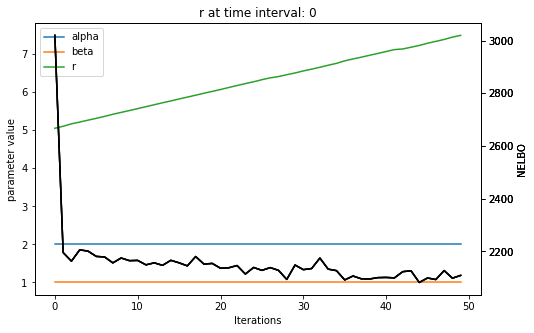

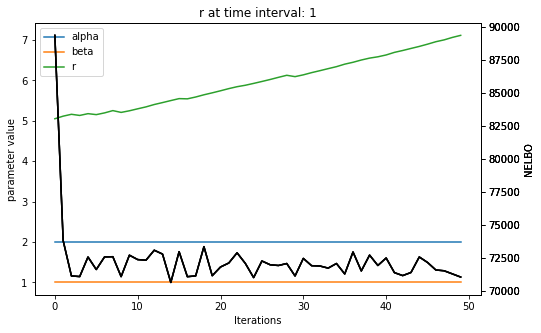

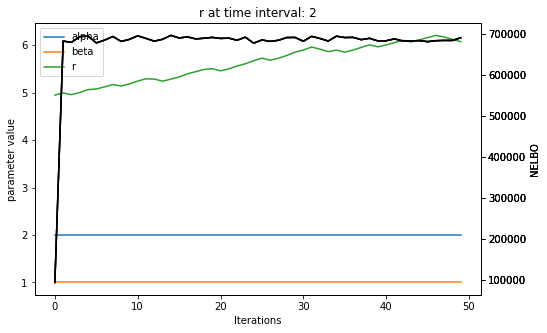

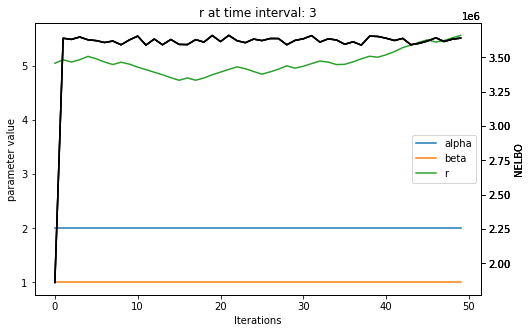

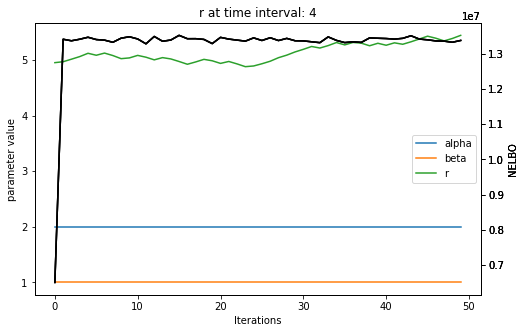

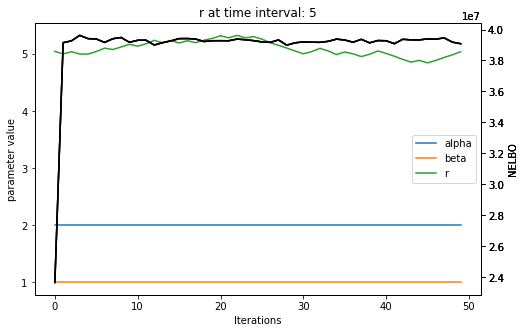

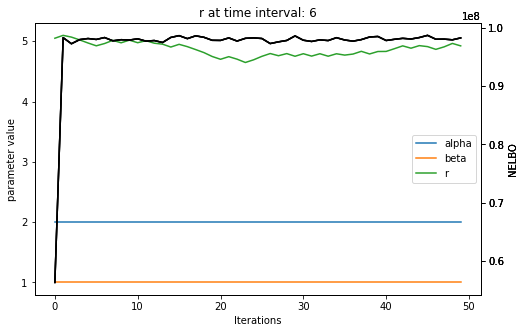

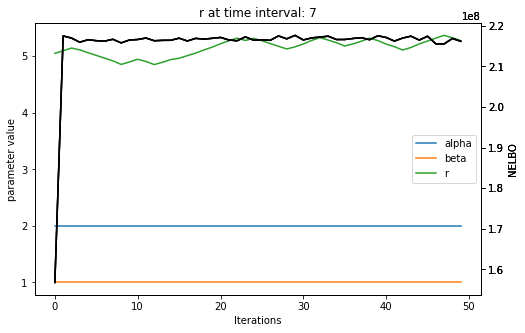

In [33]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

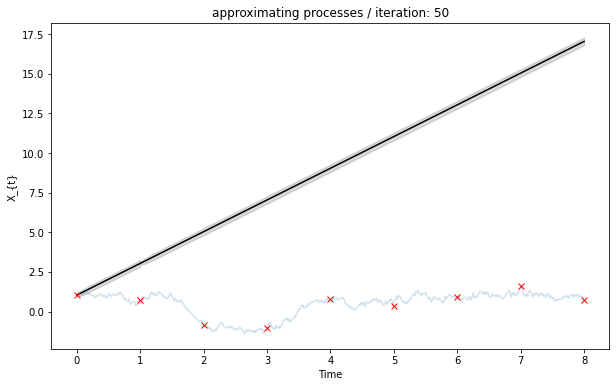

In [34]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

what if we reduce the time step by factor of 50?

In [35]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time/50, obs_sigma, \
                                                      init_state="Random", M=1500, \
#                                                       FIX_PAR = fix_pars,
#                                                                \
                                                      IT=it, vN=150, learning_rate=0.15, \
                                                      Optimizer="Adam", beta_1 = 0.5, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                                                                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

0/ alpha: 0.014928971417248249
0/ beta: -1.3236905336380005
0/ r: 5.0
0/ Negative ELBO: 3.5480859684093975
1/ Negative ELBO: 3.4115596482705635
2/ Negative ELBO: 2.9846598896963497
3/ Negative ELBO: 2.994838325575079
4/ Negative ELBO: 2.810343575216344
5/ Negative ELBO: 2.667625438096319
6/ Negative ELBO: 2.198137550059304
7/ Negative ELBO: 2.118678953035417
8/ Negative ELBO: 1.9305940505741146
9/ Negative ELBO: 1.754635727552028
10/ Negative ELBO: 1.6807163249336772
11/ Negative ELBO: 1.5390339967074014
12/ Negative ELBO: 1.4039798150862892
13/ Negative ELBO: 1.251982227674739
14/ Negative ELBO: 1.198518671493229
15/ Negative ELBO: 1.068373860187709
16/ Negative ELBO: 1.2055548398390799
17/ Negative ELBO: 1.2510487806203676
18/ Negative ELBO: 1.3678477470327477
19/ Negative ELBO: 1.6441392338821328
20/ Negative ELBO: 2.0537033142872816
21/ Negative ELBO: 2.885336269157616
22/ Negative ELBO: 9.552153989951641
23/ Negative ELBO: 8.921348626106807
24/ Negative ELBO: 7.951215713658479
25/


 12%|███████████████████████████████▍                                                                                                                                                                                                                           | 1/8 [00:04<00:29,  4.22s/it]

47/ Negative ELBO: 2.9731857441215617
48/ Negative ELBO: 3.8731922215081394
49/ Negative ELBO: 4.3254195654681755
observation: 0.7418740051633642 variational mean: 0.699271886490082
0/ alpha: 0.5261303186416626
0/ beta: 0.05594925582408905
0/ r: 5.0
0/ Negative ELBO: 120.86846979825637
1/ Negative ELBO: 120.00098051797583
2/ Negative ELBO: 119.60767069647292
3/ Negative ELBO: 119.59070930687759
4/ Negative ELBO: 120.05923566867182
5/ Negative ELBO: 118.98037040234524
6/ Negative ELBO: 117.59039022865235
7/ Negative ELBO: 117.28654955090589
8/ Negative ELBO: 115.88650278066397
9/ Negative ELBO: 115.24907527620952
10/ Negative ELBO: 114.73999058232802
11/ Negative ELBO: 113.32613614163935
12/ Negative ELBO: 112.08759551153518
13/ Negative ELBO: 110.87842247448877
14/ Negative ELBO: 109.09171038866813
15/ Negative ELBO: 106.77786939619004
16/ Negative ELBO: 105.37026719070717
17/ Negative ELBO: 103.62648767260606
18/ Negative ELBO: 102.11034818951578
19/ Negative ELBO: 99.8730948806147
20


 25%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 2/8 [00:08<00:25,  4.26s/it]

47/ Negative ELBO: 54.00039454971779
48/ Negative ELBO: 53.53524227972806
49/ Negative ELBO: 54.96639048199078
observation: -0.8564873337841266 variational mean: -0.3286004662513733
0/ alpha: 1.2420496940612793
0/ beta: -1.263343095779419
0/ r: 5.0
0/ Negative ELBO: 24.806947799486196
1/ Negative ELBO: 24.595873187750815
2/ Negative ELBO: 22.79592409604684
3/ Negative ELBO: 22.44598365258833
4/ Negative ELBO: 21.659174323142473
5/ Negative ELBO: 20.884061979333225
6/ Negative ELBO: 20.066627687837734
7/ Negative ELBO: 19.490357664700458
8/ Negative ELBO: 18.539899533971557
9/ Negative ELBO: 17.691911097719643
10/ Negative ELBO: 17.162105494174124
11/ Negative ELBO: 16.393648239229567
12/ Negative ELBO: 15.788324687184247
13/ Negative ELBO: 14.872125004281154
14/ Negative ELBO: 14.405182290555313
15/ Negative ELBO: 13.791729426165666
16/ Negative ELBO: 13.04409609756986
17/ Negative ELBO: 12.28388192152217
18/ Negative ELBO: 11.604327444213064
19/ Negative ELBO: 11.577647406141477
20/ N


 38%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3/8 [00:12<00:21,  4.26s/it]

48/ Negative ELBO: 22.818177895967032
49/ Negative ELBO: 23.423913269546247
observation: -1.0673319792395932 variational mean: -1.1072578430175781
0/ alpha: -0.10079902410507202
0/ beta: 0.18615944683551788
0/ r: 5.0
0/ Negative ELBO: 182.0267770011599
1/ Negative ELBO: 181.5092452203896
2/ Negative ELBO: 181.73900917012946
3/ Negative ELBO: 181.33922582897478
4/ Negative ELBO: 179.47735505038415
5/ Negative ELBO: 180.50868889466352
6/ Negative ELBO: 179.21911260315593
7/ Negative ELBO: 177.53134397282759
8/ Negative ELBO: 177.98459088167078
9/ Negative ELBO: 177.96938823195515
10/ Negative ELBO: 174.67710653171804
11/ Negative ELBO: 175.1453694792207
12/ Negative ELBO: 174.0452091326533
13/ Negative ELBO: 171.25813334772457
14/ Negative ELBO: 168.9758772905459
15/ Negative ELBO: 165.98304439862878
16/ Negative ELBO: 164.50265973398064
17/ Negative ELBO: 160.8501007625953
18/ Negative ELBO: 159.9065420610362
19/ Negative ELBO: 157.88646603382207
20/ Negative ELBO: 155.94004055172792
21


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 4/8 [00:17<00:17,  4.25s/it]

49/ Negative ELBO: 80.89660985643954
observation: 0.7995340035602375 variational mean: 0.006057620048522949
0/ alpha: 0.2509993016719818
0/ beta: -0.2879931628704071
0/ r: 5.0
0/ Negative ELBO: 7.8591489686577845
1/ Negative ELBO: 8.009804440468457
2/ Negative ELBO: 7.149033512440372
3/ Negative ELBO: 7.754265795509256
4/ Negative ELBO: 8.091224346297645
5/ Negative ELBO: 8.202399276918118
6/ Negative ELBO: 7.5537252346780415
7/ Negative ELBO: 7.728059782460103
8/ Negative ELBO: 7.883884963568878
9/ Negative ELBO: 7.846245041318249
10/ Negative ELBO: 8.107673113518185
11/ Negative ELBO: 7.610416034450619
12/ Negative ELBO: 7.5380469823274225
13/ Negative ELBO: 7.721274561611598
14/ Negative ELBO: 7.630026553426154
15/ Negative ELBO: 7.085555947372212
16/ Negative ELBO: 7.659672531948357
17/ Negative ELBO: 6.770840613947447
18/ Negative ELBO: 7.341638956245069
19/ Negative ELBO: 6.534939442522191
20/ Negative ELBO: 6.6088187460218855
21/ Negative ELBO: 6.31502142651318
22/ Negative ELBO


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 5/8 [00:21<00:12,  4.25s/it]

47/ Negative ELBO: 5.658024742920821
48/ Negative ELBO: 6.50727394885301
49/ Negative ELBO: 7.354173096021566
observation: 0.3540452486520327 variational mean: 0.5420119762420654
0/ alpha: -0.4148830473423004
0/ beta: -0.3578220307826996
0/ r: 5.0
0/ Negative ELBO: 7.495724686572687
1/ Negative ELBO: 7.493373335835239
2/ Negative ELBO: 6.977156988932919
3/ Negative ELBO: 6.932967160757399
4/ Negative ELBO: 6.749891876356836
5/ Negative ELBO: 6.520273052626133
6/ Negative ELBO: 6.104774519167821
7/ Negative ELBO: 6.096599281997206
8/ Negative ELBO: 5.750066841314851
9/ Negative ELBO: 5.569547213969759
10/ Negative ELBO: 4.905017378444256
11/ Negative ELBO: 4.5408209872533325
12/ Negative ELBO: 4.516335617123825
13/ Negative ELBO: 4.331469491287286
14/ Negative ELBO: 3.881254232453414
15/ Negative ELBO: 3.4626551678908983
16/ Negative ELBO: 3.4611138771568974
17/ Negative ELBO: 3.0887272836503774
18/ Negative ELBO: 3.036744054094795
19/ Negative ELBO: 2.8170953926588567
20/ Negative ELBO


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6/8 [00:25<00:08,  4.24s/it]

48/ Negative ELBO: 6.599690179200064
49/ Negative ELBO: 4.881501201726253
observation: 0.9328201877376548 variational mean: 0.9306243658065796
0/ alpha: -0.7391933798789978
0/ beta: 0.497871994972229
0/ r: 5.0
0/ Negative ELBO: 25.932320825720343
1/ Negative ELBO: 24.841741398516927
2/ Negative ELBO: 25.45339597446389
3/ Negative ELBO: 25.056540508584447
4/ Negative ELBO: 25.079183248546233
5/ Negative ELBO: 25.304020961942335
6/ Negative ELBO: 25.108945907915857
7/ Negative ELBO: 24.975597979817024
8/ Negative ELBO: 25.208274886567516
9/ Negative ELBO: 25.10643564346069
10/ Negative ELBO: 24.657898061207554
11/ Negative ELBO: 24.061406543480512
12/ Negative ELBO: 24.034322643843282
13/ Negative ELBO: 23.866923687846054
14/ Negative ELBO: 23.59415298283738
15/ Negative ELBO: 23.585159342465175
16/ Negative ELBO: 22.931148158684994
17/ Negative ELBO: 22.568577482424143
18/ Negative ELBO: 22.440373939926754
19/ Negative ELBO: 21.27005334734398
20/ Negative ELBO: 21.24283383418214
21/ Neg


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7/8 [00:29<00:04,  4.24s/it]

49/ Negative ELBO: 23.50071366800874
observation: 1.6311081388826472 variational mean: 1.559894323348999
0/ alpha: -0.1424540877342224
0/ beta: 0.029292870312929153
0/ r: 5.0
0/ Negative ELBO: 38.33842197175867
1/ Negative ELBO: 37.823191586501466
2/ Negative ELBO: 38.017428075643956
3/ Negative ELBO: 37.812531330889605
4/ Negative ELBO: 36.96120911805099
5/ Negative ELBO: 37.60871040065624
6/ Negative ELBO: 36.84136215759401
7/ Negative ELBO: 35.40267752449098
8/ Negative ELBO: 34.901017226800505
9/ Negative ELBO: 34.85887954794234
10/ Negative ELBO: 33.60357091394279
11/ Negative ELBO: 33.022522128257734
12/ Negative ELBO: 32.346096803029624
13/ Negative ELBO: 31.590020206955067
14/ Negative ELBO: 29.825565435811164
15/ Negative ELBO: 29.287639593658046
16/ Negative ELBO: 28.14142177622288
17/ Negative ELBO: 27.569489514404392
18/ Negative ELBO: 26.16517068070994
19/ Negative ELBO: 25.638437084707732
20/ Negative ELBO: 23.99926465073362
21/ Negative ELBO: 22.898905433016346
22/ Negat


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.93s/it]

47/ Negative ELBO: 140.95121662769392
48/ Negative ELBO: 126.88228058698039
49/ Negative ELBO: 108.16129864135988
observation: 0.708966867981579 variational mean: 0.10677385330200195


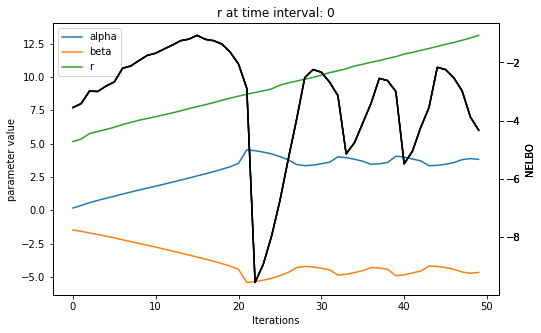

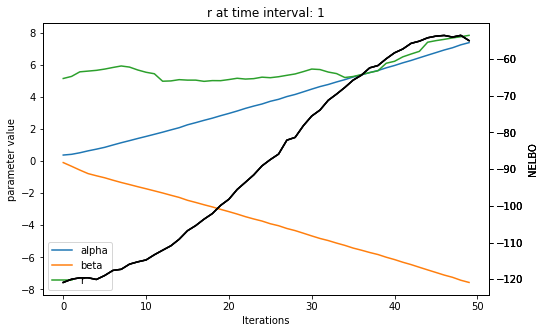

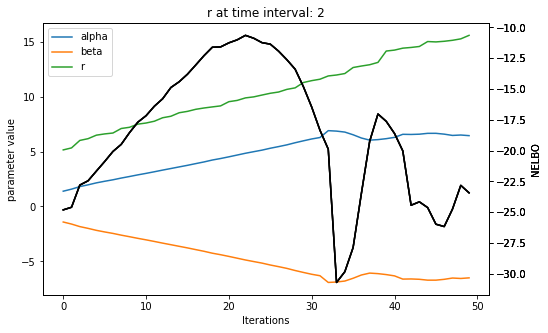

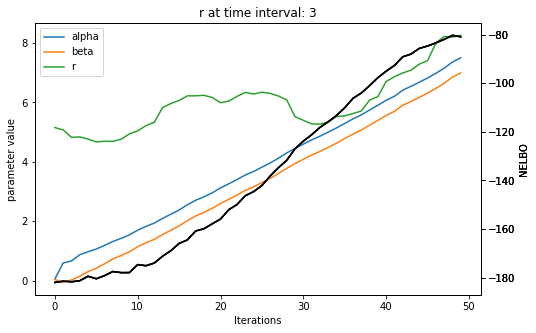

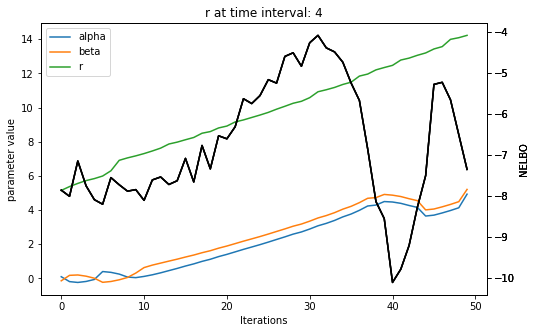

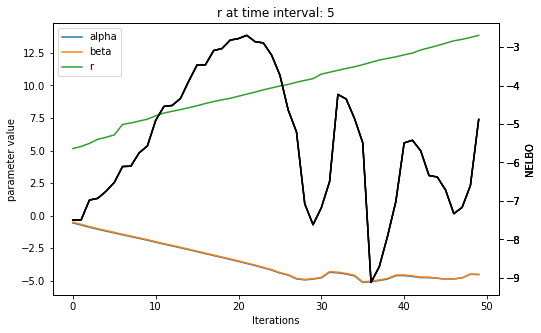

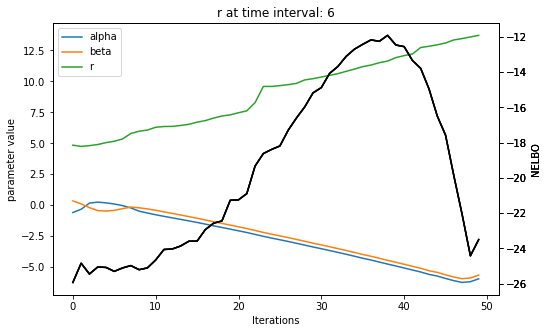

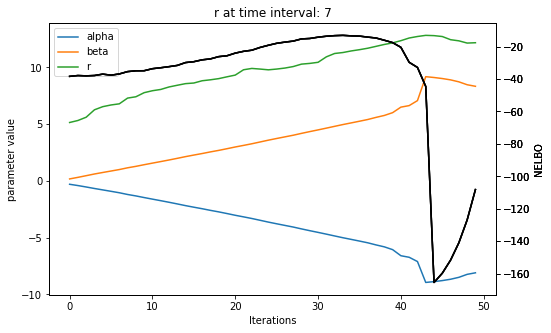

In [36]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(-1 * vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

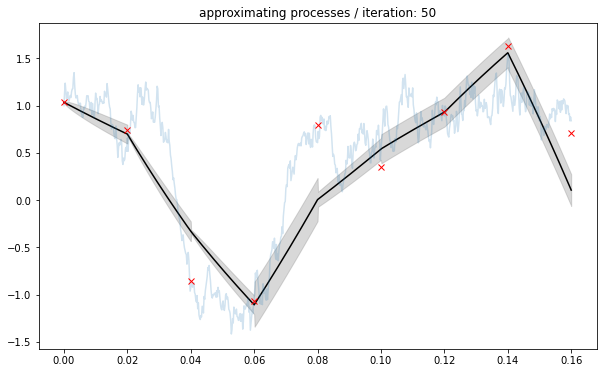

In [37]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts/50, true_sde_trj, alpha=0.2)
    plt.plot(obs_time/50, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

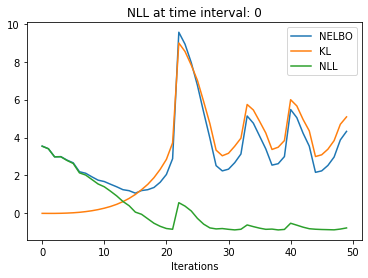

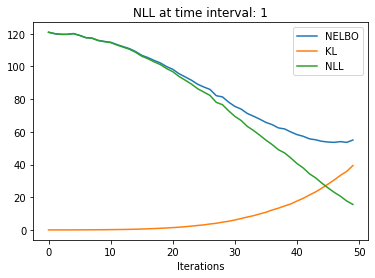

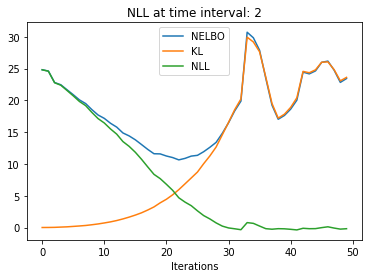

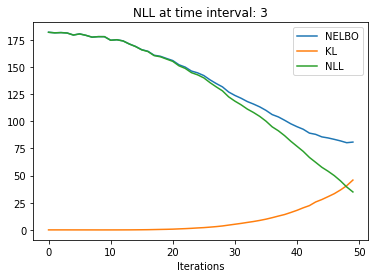

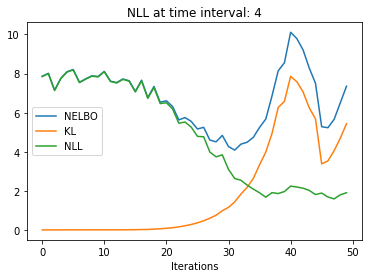

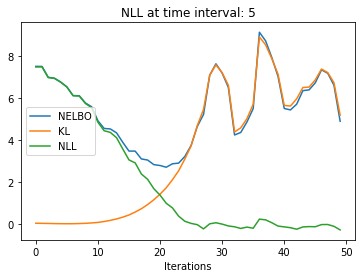

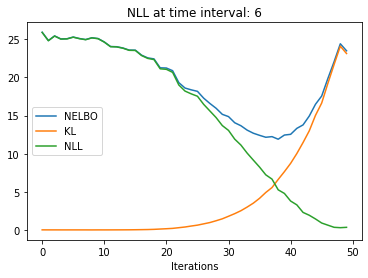

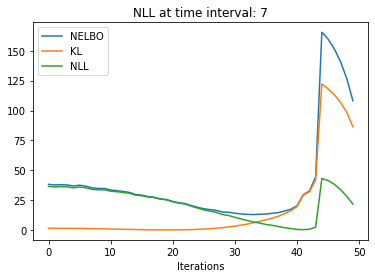

In [38]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()